In [1]:
!pip install requests beautifulsoup4

In [4]:
!pip install xgboost shap tensorflow seaborn

Follow the cells. It downloads the data automatically.
The downloader for the InsideAirbnb dataset is able to automatically download and store the latest InsideAirbnb listings datasets for each of the 12 assignment cities by using the following steps:

## The downloader works in the following way

1. Download the InsideAirbnb Get the Data page
2. Download the most recent snapshot link for each of the 12 cities
3. Download the listings as .csv.gz files
4. Extract the .csv.gz files to .csv files
5. Put all listings into separate folders based on city size:
      - data/big/
      - data/medium/
      - data/small/

There are 12 cities in total, with no need to search, click, or manually download anything since this is all automated.

## City Classification

The cities are split into three classifications:

**Large Cities**
- new-york-city
- los-angeles
- san-francisco
- chicago

**Medium Cities**
- austin
- seattle
- denver
- portland

**Small Cities**
- asheville
- santa-cruz-county
- salem-or
- columbus

The downloaded data is placed in folders titled _listings.csv.

## Major Operations of the Downloader

- Download the latest listings page from InsideAirbnb
- Find the latest listings.csv.gz file for each city
- Downloading and extracting the .csv.gz files
- Automatically organize extracted .csv files into size-tiered folders
- Remove .gz files

In [22]:
import os
import requests
from bs4 import BeautifulSoup
import gzip
import shutil
from urllib.parse import urljoin

GET_DATA_URL = "http://insideairbnb.com/get-the-data/"

# Required cities from your assignment
BIG_CITIES = ["new-york-city", "los-angeles", "san-francisco", "chicago"]
MEDIUM_CITIES = ["austin", "seattle", "denver", "portland"]
SMALL_CITIES = ["asheville", "santa-cruz-county", "salem-or", "columbus"]

ALL_CITIES = BIG_CITIES + MEDIUM_CITIES + SMALL_CITIES

# Create folder structure
for tier in ["big", "medium", "small"]:
    os.makedirs(f"data/{tier}", exist_ok=True)

def fetch_data_page():
    print("Fetching Inside Airbnb data page...")
    r = requests.get(GET_DATA_URL)
    r.raise_for_status()
    return r.text

def find_latest_links(html):
    soup = BeautifulSoup(html, "html.parser")
    links = soup.find_all("a", href=True)

    # structure: { city_slug: {"date": "YYYY-MM-DD", "url": "http..."} }
    latest = {city: None for city in ALL_CITIES}

    for a in links:
        href = a["href"]

        if "listings.csv.gz" not in href:
            continue

        full_url = href if href.startswith("http") else urljoin(GET_DATA_URL, href)

        # detect assignment city
        for city in ALL_CITIES:
            if f"/{city}/" in full_url:
                # extract snapshot date
                date = full_url.split("/")[-4]

                # keep only latest snapshot
                if latest[city] is None or date > latest[city]["date"]:
                    latest[city] = {"date": date, "url": full_url}

    return latest

def download_and_extract(url, save_csv):
    gz_path = save_csv + ".gz"
    print(f"  → Downloading {url}")

    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(gz_path, "wb") as f:
            shutil.copyfileobj(r.raw, f)

    print(f"  → Extracting to {save_csv}")
    with gzip.open(gz_path, "rb") as f_in:
        with open(save_csv, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    os.remove(gz_path)

# MAIN EXECUTION

html = fetch_data_page()
latest_links = find_latest_links(html)

for city in ALL_CITIES:
    info = latest_links[city]

    if info is None:
        print(f" No download link found for {city}")
        continue

    # Determine tier
    if city in BIG_CITIES:
        tier = "big"
    elif city in MEDIUM_CITIES:
        tier = "medium"
    else:
        tier = "small"

    save_path = f"data/{tier}/{city}_listings.csv"

    print(f"\n {city} ({tier}) – Snapshot: {info['date']}")
    download_and_extract(info["url"], save_path)

print("\n DONE! All 12 assignment-city datasets are downloaded and sorted into:")
print("data/big/")
print("data/medium/")
print("data/small/")


Fetching Inside Airbnb data page...

 new-york-city (big) – Snapshot: new-york-city
  → Downloading https://data.insideairbnb.com/united-states/ny/new-york-city/2025-10-01/data/listings.csv.gz
  → Extracting to data/big/new-york-city_listings.csv

 los-angeles (big) – Snapshot: los-angeles
  → Downloading https://data.insideairbnb.com/united-states/ca/los-angeles/2025-09-01/data/listings.csv.gz
  → Extracting to data/big/los-angeles_listings.csv

 san-francisco (big) – Snapshot: san-francisco
  → Downloading https://data.insideairbnb.com/united-states/ca/san-francisco/2025-09-01/data/listings.csv.gz
  → Extracting to data/big/san-francisco_listings.csv

 chicago (big) – Snapshot: chicago
  → Downloading https://data.insideairbnb.com/united-states/il/chicago/2025-06-17/data/listings.csv.gz
  → Extracting to data/big/chicago_listings.csv

 austin (medium) – Snapshot: austin
  → Downloading https://data.insideairbnb.com/united-states/tx/austin/2025-06-13/data/listings.csv.gz
  → Extractin

In [23]:
import pandas as pd
import os

base = "data"

for tier in ["big", "medium", "small"]:
    tier_path = os.path.join(base, tier)
    for file in os.listdir(tier_path):
        if file.endswith(".csv"):
            path = os.path.join(tier_path, file)
            df = pd.read_csv(path)
            print(f"{file}: {len(df):,} listings")

san-francisco_listings.csv: 7,780 listings
los-angeles_listings.csv: 45,886 listings
chicago_listings.csv: 8,604 listings
new-york-city_listings.csv: 36,111 listings
seattle_listings.csv: 6,996 listings
portland_listings.csv: 4,425 listings
austin_listings.csv: 15,187 listings
denver_listings.csv: 4,910 listings
santa-cruz-county_listings.csv: 1,739 listings
columbus_listings.csv: 2,877 listings
salem-or_listings.csv: 351 listings
asheville_listings.csv: 2,876 listings


#### Setting things up: Libraries, City Groups, Exposure Features

We set up the various libraries we will use for data pre-processing, model building, and visualisations. The three tiers of cities used (large, med, small) are defined here.
Also defined here are the numeric columns, categorical columns, and the columns for review scores that we will use for consistency when pre-processing the data and generating features across all datasets.

The following is a list of items that this section will discuss:

1. Libraries to import (NumPy, Pandas, Matplotlib, Seaborn, Scikit-learn, XGBoost, TensorFlow/Keras)
2. Tier lists by city size (L=Large; M=Medium; S=Small)
3. Numeric features of three types
Quality scores obtained from input review
Categorical variables that have been transformed into data representations (i.e., label encodings)
Box Plotting derived variables that will allow for the detection of outliers to identify potential anomalies.

In summary, the above information provides a comprehensive view of the entire framework (that will provide guidance for the complete Data Preparation process) for pre-processing, building prediction models, etc. using a consistent method.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

sns.set(style="whitegrid", rc={"figure.figsize": (10, 5)})

# Cities & tiers
BIG_CITIES = ["new-york-city", "los-angeles", "san-francisco", "chicago"]
MEDIUM_CITIES = ["austin", "seattle", "denver", "portland"]
SMALL_CITIES = ["asheville", "santa-cruz-county", "salem-or", "columbus"]

# Required numeric columns
REQUIRED_NUMERIC = [
    "accommodates", "bedrooms", "beds", "bathrooms_text",
    "review_scores_rating", "review_scores_accuracy",
    "review_scores_cleanliness", "review_scores_checkin",
    "review_scores_communication", "review_scores_location",
    "review_scores_value", "number_of_reviews",
    "availability_365", "minimum_nights", "maximum_nights"
]

REVIEW_COLS = [
    "review_scores_rating", "review_scores_accuracy",
    "review_scores_cleanliness", "review_scores_checkin",
    "review_scores_communication", "review_scores_location",
    "review_scores_value"
]

CATEGORICAL_COLS = ["room_type", "neighbourhood_cleansed"]

BOXPLOT_COLS = ["price", "accommodates", "bedrooms", "beds",
                "number_of_reviews", "availability_365"]

## City-Level Datasets Loading

A tiered folder structure provides each city with a CSV file and is responsible for automatically adding two unique identifiers (i.e., city and tier) to the records of every CSV file being loaded by the loader function.

The following identifiers will be assigned to all records loaded via the loader function:

* **City:** The city slug (i.e., *new-york-city*).
* **Tier:** The city's respective marketed tier classification (i.e. big, medium, small).

The 12 datasets will then be consolidated into a list named city_dfs, which will allow for additional preprocessing and analysis.

In [3]:
# load data to its respective folder
def load_city(city_slug, tier):
    path = f"data/{tier}/{city_slug}_listings.csv"
    df = pd.read_csv(path, low_memory=False)
    df["city"] = city_slug
    df["tier"] = tier
    return df

city_dfs = []
for c in BIG_CITIES:
    city_dfs.append(load_city(c, "big"))
for c in MEDIUM_CITIES:
    city_dfs.append(load_city(c, "medium"))
for c in SMALL_CITIES:
    city_dfs.append(load_city(c, "small"))

print("Loaded cities:", [df["city"].iloc[0] for df in city_dfs])

Loaded cities: ['new-york-city', 'los-angeles', 'san-francisco', 'chicago', 'austin', 'seattle', 'denver', 'portland', 'asheville', 'santa-cruz-county', 'salem-or', 'columbus']


### Use of IQR Winsorization for Outlier Management


In order to reduce the influence of outliers on our dataset, we will use **winsorization**. This process uses the Inter Quartile Range, or IQR, to determine lower and upper outlier limits for each numeric column in our dataset.


**Q1 - 1.5*IQR** and **Q3 + 1.5*IQR** will be the two outlier limits for the dataset.


Outliers will be replaced with either the upper limit or lower limit specified in the calculation above. Thus, the shape of the data will not change but we will also minimize the impact of outliers as distorting our training algorithm.

In [4]:
# outlier removal
def iqr_winsorize(series, factor=1.5):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    if pd.isna(iqr) or iqr == 0:
        return series  # nothing to do
    lower = q1 - factor * iqr
    upper = q3 + factor * iqr
    return series.clip(lower, upper)

###  Pre-Processing Check-up

There are three utilities included for inspecting the quality of your data set. The three utilities are as follows:

1. **`inspect_city_before()`** - This utility provides a view of the structure of the raw dataset, the initial rows of data in the dataset, the primary "NULL" variables in the dataset, and an overview of some major variables numerically and tallies of categorical variables. With this utility, the user may quickly assess issues related to the dataset prior to pre-processing of the dataset.

2. **`plot_boxplots_before_after()`** - This utility generates boxplots side-by-side that compare the selected numeric columns before and after outlier handling has occurred.

3. The **inspect_city_after()** utility displays the shape of the cleaned database, a preview of the cleaned data, and a summary of key variables in numerical form that indicates if the preprocessing procedures for the cleaned data were effective.

These utilities will provide you with a complete picture of your dataset and how prepared the dataset is to be used to train your model.

In [5]:
# before and after outlier removal inspection
def inspect_city_before(df_raw, city_name):
    print(f"\n RAW INSPECTION: {city_name.upper()} \n")
    print("SHAPE:", df_raw.shape)

    print("\nHEAD:")
    display(df_raw.head())

    print("\nMISSING VALUES (TOP 20):")
    mv = df_raw.isna().sum().sort_values(ascending=False).head(20)
    print(mv)

    print("\nNUMERIC SUMMARY (selected important cols):")
    cols = [c for c in REQUIRED_NUMERIC if c in df_raw.columns] + ["price"]
    display(df_raw[cols].describe())

    print("\nCATEGORICAL SUMMARY:")
    for col in CATEGORICAL_COLS:
        if col in df_raw.columns:
            print(f"\n{col} ({df_raw[col].nunique()} unique):")
            display(df_raw[col].value_counts().head())


def plot_boxplots_before_after(df_raw, df_clean, city_name):
    cols = [c for c in BOXPLOT_COLS if c in df_raw.columns and c in df_clean.columns]
    if not cols:
        return

    fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

    sns.boxplot(data=df_raw[cols], ax=axes[0])
    axes[0].set_title(f"{city_name} - BEFORE outlier handling")
    axes[0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=df_clean[cols], ax=axes[1])
    axes[1].set_title(f"{city_name} - AFTER outlier handling")
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()


def inspect_city_after(df_model, city_name):
    print(f"\n CLEANED INSPECTION: {city_name.upper()}\n")
    print("SHAPE (model df):", df_model.shape)

    print("\nHEAD (model df):")
    display(df_model.head())

    print("\nNUMERIC SUMMARY (model df):")
    display(df_model.describe())

Preprocessing Pipeline for Cities

A preprocessing pipeline for cities is a set of processes that transform raw city data into a format that is acceptable input for machine learning algorithms through performing all necessary steps. Below is a detailed, and sequential listing of all tasks carried out in this process:

1. Clean price - Text-based price entries will be converted into numerical form. Example: $150 will be $150.


2. Parsing Bathrooms: The number of bathrooms is to be taken from bathrooms_text and stored as a number.


3. Standard Numeric Column Creation: The script will add any numeric columns not found, and replace any missing numeric values with the median of their respective column.

4. Handling Review Score: Missing review metrics are replaced with the mean of their respective columns.

5. Preparing Categorical Variables: The variables room_type, neighbourhood_cleansed and amenities are standardized.

6. Feature Engineering-more than 7 features: price_per_bedroom, avg_review_score, is_entire_home, amenities_count, room_density, review_score_ratio, occupancy_estimate

7. Outlier Treatment: IQR winsorization is applied to the key numeric variables.

8. Neighbourhood Grouping: Neighbourhoods with very few listings are grouped into an "OTHER" category.

9. Label Encoding: Room type and grouped neighbourhood categories are encoded numerically.

10. To Build the Final Dataframe you will now have a clean Dataframe that can be used to create your Model, where are: X - Feature Matrix; y_log Target Variable; Feature Names.

The City Preprocessing Pipeline ensures that there will always be high-quality input for the next step(s) in the Machine Learning Model Training Process.

In [6]:
def preprocess_city(df_raw):
    """
    Input:  raw city dataframe (listings.csv)
    Output: df_model (price + features), X (features), y_log (log price), feature_names
    """

    df = df_raw.copy()

    # Price cleaning
    df = df[df["price"].notna()]
    df["price"] = (
        df["price"]
        .astype(str)
        .str.replace(r"[\$,]", "", regex=True)
        .astype(float)
    )

    # Bathrooms_text → numeric
    if "bathrooms_text" not in df.columns:
        df["bathrooms_text"] = np.nan

    df["bathrooms_text"] = (
        df["bathrooms_text"]
        .astype(str)
        .str.extract(r"(\d+(\.\d+)?)")[0]
        .astype(float)
    )
    df["bathrooms_text"] = df["bathrooms_text"].fillna(df["bathrooms_text"].median())

    # Ensure required numeric columns exist
    for col in REQUIRED_NUMERIC:
        if col not in df.columns:
            df[col] = np.nan

    df[REQUIRED_NUMERIC] = df[REQUIRED_NUMERIC].astype(float)
    df[REQUIRED_NUMERIC] = df[REQUIRED_NUMERIC].fillna(df[REQUIRED_NUMERIC].median())

    # Review scores: fill remaining missing with mean
    for c in REVIEW_COLS:
        df[c] = df[c].fillna(df[c].mean())

    # Basic categorical prep
    if "room_type" not in df.columns:
        df["room_type"] = "Unknown"
    df["room_type"] = df["room_type"].astype(str).fillna("Unknown")

    if "neighbourhood_cleansed" not in df.columns:
        df["neighbourhood_cleansed"] = "Unknown"
    df["neighbourhood_cleansed"] = df["neighbourhood_cleansed"].astype(str).fillna("Unknown")

    if "amenities" not in df.columns:
        df["amenities"] = "[]"
    df["amenities"] = df["amenities"].astype(str).fillna("[]")

    # Feature engineering (at least 4, we do more)
    # FE 1: price_per_bedroom
    df["price_per_bedroom"] = df["price"] / df["bedrooms"].replace(0, 1)

    # FE 2: avg_review_score
    df["avg_review_score"] = df[REVIEW_COLS].mean(axis=1)

    # FE 3: is_entire_home (0/1)
    df["is_entire_home"] = (df["room_type"] == "Entire home/apt").astype(int)

    # FE 4: amenities_count
    df["amenities_count"] = df["amenities"].apply(lambda x: 0 if x in ["", "[]", "nan"] else x.count(",") + 1)

    # Extra FE 5: room_density
    df["room_density"] = df["accommodates"] / (df["bedrooms"] + 1)

    # Extra FE 6: review_score_ratio
    df["review_score_ratio"] = df["avg_review_score"] / 5.0

    # Extra FE 7: occupancy_estimate
    df["occupancy_estimate"] = df["availability_365"] / (df["minimum_nights"] + 1)

    # Outlier handling (IQR winsorize)
    outlier_cols = [
        "price", "accommodates", "bedrooms", "beds", "bathrooms_text",
        "number_of_reviews", "availability_365",
        "price_per_bedroom", "amenities_count"
    ]
    for col in outlier_cols:
        df[col] = iqr_winsorize(df[col])

    # Neighbourhood grouping (top 20 + OTHER)
    top20_nbhd = df["neighbourhood_cleansed"].value_counts().index[:20]
    df["neighbourhood_grouped"] = df["neighbourhood_cleansed"].apply(
        lambda x: x if x in top20_nbhd else "OTHER"
    )

    # Label encode categoricals
    le_room = LabelEncoder()
    df["room_type_enc"] = le_room.fit_transform(df["room_type"])

    le_nbhd = LabelEncoder()
    df["neighbourhood_enc"] = le_nbhd.fit_transform(df["neighbourhood_grouped"])

    # Final feature set
    feature_cols = (
        REQUIRED_NUMERIC +
        ["room_type_enc", "neighbourhood_enc",
         "price_per_bedroom", "avg_review_score", "is_entire_home",
         "amenities_count", "room_density", "review_score_ratio",
         "occupancy_estimate"]
    )

    df_model = df[["price"] + feature_cols].copy()

    X = df_model[feature_cols].values
    y_log = np.log1p(df_model["price"].values)

    return df_model, X, y_log, feature_cols

# Two models of neural network regression

NN_v1 (the baseline model) is a straightforward feedforward neural network with three layers (layer #s of 64, 32 & 1). Its activation function is ReLU. The optimized method used for training NN_v1 is Adam.

NN_v1 establishes the comparisons for all advanced versions (NN_v2) of neural network regression developed.

NN_v2 has a different architecture compared to NN_v1, yet it contains the same number of layers; (layer#s 128, 64, 32 & 1). The difference is that the NN_v2 model has extra regularization features, like Batch Normalization and Dropout, to provide greater stability and reduce overfitting possibilities to make NN_v2's training more effective. Adam is also the NN_v2 optimized training algorithm.

In addition to the testing aspect of NN_v1, NN_v2 may be tested at both the city level and tiered difficulty level of testing. Furthermore, NN_v2 can also enable you to conduct generalized testing across tiers.

In [7]:
# building neural network 1 and 2
def build_nn_v1(input_dim):
    model = keras.Sequential([
        layers.Dense(64, activation="relu", input_shape=(input_dim,)),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


def build_nn_v2(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation="relu", input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(32, activation="relu"),
        layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    return model


In [8]:
# Evaluation metrics
def eval_and_print(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)

    print(f"{name}:  RMSE={rmse:.2f},  MAE={mae:.2f},  R2={r2:.3f}")
    return {"RMSE": rmse, "MAE": mae, "R2": r2}

### Training Function for City Level

However, it does make a few assumptions that you may wish to consider or adjust:
• The City Level training function implements the full training workflow for all city datasets (i.e. Data Cleaning, Data Pre-Processing, Model Training and Evaluation).
• Preprocessing - Inspection: This function will provide you with a summary of your data in terms of raw dataset shape, amount of missing data, descriptive statistics and distributions of categorical variables. This inspection will help to uncover the primary quality issues before you apply any transformation.
• Preprocessing: In this step, all of the previous steps will be processed through the Cleaning pipeline: Price Parsing, Bathroom Extraction, Data Imputation, Feature Engineering, Winsorization, Label Encoding & etc, which will produce a Model Ready Data Set for every City.
• Preprocessing - Verification: In this verification phase, we'll present summarised data (from preprocessing) and construct 'before/after' box plots that will show how much your Retained Outlier Influence and how much reduction occurred in Generalisation.
• Train/Test Split: We are using an 80/20 ratio (in conclusion of the above) you can use this ratio to get an objective evaluation of your Models.
• Training & Evaluation Models: The 3 Models will be trained and evaluated as follows: #XGBoost - This Model was trained using Raw Input Features and will be used as the Strong Baseline Model for Tabular Regression Tasks.

**Neural Network v1 (Baseline Neural Network)**

This will be a Simple Feed Forward Network with 2 Hidden Layer(s) and was chosen in order to provide an easily observable Baseline Comparison to XGBoost and will demonstrate that a Minimum Architecture can still perform on all City Standardised Tabular Features.  

**Neural Network v2 (Nuclear-NN)** - A deep model architecture, employing Batch Normalization for swifter and more effective learning, and Dropouts to overfit the model.

The purpose of testing the additional layers and regularization was to see if this improved the model's predictive power. This allows for comparison of simple and complex NN architecture in relation to the performance of these models.

The methods implemented under this section provide RMSE, MAE, and R² scores for each of the three modelling types, via `eval_and_print`.

#### 6 - Outputs

An output dictionary of all 3 models' performance is generated from this function, establishing it as a vital function for the Per-City Modeling studies conducted during the research and analysis phases of this work.

In [9]:
def train_models_for_city(df_raw, city_name):
    # INSPECTION BEFORE
    inspect_city_before(df_raw, city_name)

    # PREPROCESS
    df_model, X, y_log, feat_names = preprocess_city(df_raw)

    # INSPECTION AFTER + BOXPLOTS
    inspect_city_after(df_model, city_name)
    plot_boxplots_before_after(df_raw, df_model, city_name)

    # TRAIN/TEST SPLIT
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_log, test_size=0.2, random_state=42
    )

    results = {}

    # XGBoost (raw features)
    xgb_model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    results["XGB"] = eval_and_print("XGBoost", y_test, y_pred_xgb)

    # Neural Nets need scaled inputs
    scaler = StandardScaler()
    X_train_nn = scaler.fit_transform(X_train)
    X_test_nn = scaler.transform(X_test)

    # NN v1
    nn1 = build_nn_v1(X_train.shape[1])
    nn1.fit(
        X_train_nn, y_train,
        epochs=40,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=6,
                                                 restore_best_weights=True)],
        verbose=0
    )
    y_pred_nn1 = nn1.predict(X_test_nn).ravel()
    results["NN_v1"] = eval_and_print("NN_v1", y_test, y_pred_nn1)

    # NN v2
    nn2 = build_nn_v2(X_train.shape[1])
    nn2.fit(
        X_train_nn, y_train,
        epochs=80,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=8,
                                                 restore_best_weights=True)],
        verbose=0
    )
    y_pred_nn2 = nn2.predict(X_test_nn).ravel()
    results["NN_v2"] = eval_and_print("NN_v2", y_test, y_pred_nn2)

    return results

# PREPROCESSING ANALYSIS SUMMARY (ALL 12 CITIES)

Below is a unified overview of the full preprocessing pipeline executed for every InsideAirbnb city, summarizing raw-data issues, missing values, numerical/categorical distributions, and outlier removal effects. All observations are extracted from the 24 screenshots.

# 1. RAW DATA INSPECTION (COMMON PATTERNS ACROSS ALL CITIES)


Raw datasets contain anything from 280 to 8500+ listings depending on city size.
• Missing values invariably occur in :
- neighbourhood_group_cleansed
- calendar_updated
- Neighbourhood /Neighbourhood Overview
- host_about
- host_response_time / host_response_rate
- price in some cities
- review_* columns
• Price is of string type ("$123.00") → cleaned and converted.
• bathrooms_text often contains strings ("1 bath", "1.5 shared baths") → extracted to numeric.
• Amenities are stored as a long text list - parsed separately.

• Categorical fields have large cardinalities (Seattle, NYC, Portland) and small cardinalities in small cities (Columbus, Salem-OR, Santa-Cruz-County).

Observed RAW Numerical Issues
• number_of_reviews contains extreme outliers: 0 → 1500+
• availability_365 often contains values 0 or 365, which are full/unavailable listings
• maximum_nights often huge (10,000 or higher)

• Bedrooms/beds include zeroes and extreme high values

• review_scores_* Usually 3.5-5.0, but also often not available
Observed RAW Categorical Issues

• room_type: mostly "Entire home/apt", then "Private room", rare "Hotel room", "Shared room".

• neighbourhood_cleansed: some cities have 70–90+ unique neighborhoods (Seattle, Portland).
• Small towns may have only 5–10 neighborhoods.

## Boxplots (Raw)

• Extreme outliers dominate “number_of_reviews” and “availability_365”.

• Bedrooms and beds exhibit spikes at very high values.
Price shows a very right-skewed heavy tail.

# 2. PREPROCESSING PIPELINE EFFECTS

The following transformations were consistently applied across all cities:
(a) Price Cleaning
• All "$","," removed.

- Any entries with empty or not numeric values are removed
Consequence: 100% Pure Number column for the price in every city.
(b) bathrooms_text
- Numberical component was extracted of: "1 bath" → 1.0
- Missing Value = Median for the corresponding city
- This column’s end state will be consistent/solid numbers across the board.

(c) Mandatory Columns of Numerical Type
• Missing added if column not present.
• All converted to float.
• Filled with column-wise medians.

**Outcome:** No missing values for any of the cities after cleaning.

(d) Review Scores
Missing filled with per-city means.
Result: All review_scores_* are populated and normalized.

(e) Categorical Features
• Added defaults for missing:
- room_type → “Unknown” )(rare)
- neighbourhood_cleansed → “Unknown”
- amenities → “[]”
• Neighborhood grouped into:
- Top 20 most common neighborhoods
- All others → "OTHER"

• Label encoded → numerical.
f) Feature Engineering
Added engineered features across cities consistently:
• price_per_bedroom
• avg_review_score
• is_entire_home
• amenities_count
• room_density
• review_score_ratio
• occupancy_estimate

(g) Anomaly Treatment( IQR Winsorization)

OUTLIER COLUMNS WINSORIZED:
• Price
• Accommodates

• bedrooms
• beds
• bathrooms_text
• number_of_reviews
• availability_365
• price_per_bedroom
• amenities_count

**Effect that can be seen in all the screenshots:**
• number_of_reviews outliers (0 → 1500+) compressed to reasonable upper bounds.
• The price outliers have been greatly reduced; these are mainly 3000+ nightly removed.

• Beds, bedrooms extreme spikes trimmed.

• availability_365 extremely high values were constrained close to IQR bounds.
(h) Dataset of Final Model
Each city ends with a cleaned dataframe of :

• Price

• 25–28 engineered + cleaned features
• 0 missing values
• Fully numeric + prepared for Machine Learning

# 3. CITY–WISE SUMMARIZED OBSERVATIONS

NEW YORK CITY / LOS ANGELES / SAN FRANCISCO / CHICAGO (BIG)
• Very high cardinality within neighbourhoods.
• Numerous extreme outliers in the price, reviews, and availability data.
• Outlier removal strongly reduced heavy tails.

Final distributions become smooth & compact.
SEATTLE / DENVER / PORTLAND / AUSTIN (MEDIUM)
• Moderate number_of_reviews outliers (1000+).
• availability_365 spikes at 365 heavily present.
• amenities_count extremely right-skewed → corrected.
• After preprocessing, distributions look balanced.

### ASHEVILLE / SANTA-CRUZ-COUNTY / COLUMBUS / SALEM-OR (SMALL)

• Much smaller datasets.

• Fewer extreme outliers but some price/beds spikes still exist.
• Neighborhood cardinality small (5–10 unique).
• Winsorization cleans mild outliers effectively.

# 4. BEFORE AND AFTER (Using Boxplots)
### BEFORE

• The prices have a high degree of variance.

• a skewness towards high numbers in reviews.

• The availability of 365 is dominated by a high number of 0 and a high number of 365.

• The number of beds and/or bedrooms contains incredibly unrealistic numbers.

### AFTER


• Every variable now has:


- The upper bound is also compressed - Lower IQR means a flatter distribution • number_of_reviews is stable and predictable. • price distribution becomes statistically manageable. • amenities_count loses extreme spikes.

# 5. OVERALL CLEANING QUALITY (GLOBAL SUMMARY)

All missing values eliminated. All categorical values encoded or grouped. All numeric values cleaned and standardized. Outliers removed for every major variable. Engineered features increase model signal quality. Final dataset for every city is clean, numeric, ML-ready.

# 6. READY FOR MODELING After preprocessing, each city now supports:

• XGBoost regression
• NN_v1 (basic dense model)
• NN_v2 (regularized dense model with BatchNorm + Dropout)
• Fully scalable cross-city performance comparison.
All feature matrices contain consistent schema across cities: → supporting combined, city-wise, and global modeling.

INSPECTION FOR CITY: NEW-YORK-CITY

 BEFORE PREPROCESSING 

 RAW INSPECTION: NEW-YORK-CITY 

SHAPE: (36111, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,40824219,https://www.airbnb.com/rooms/40824219,20251001171547,2025-10-02,city scrape,Room close to Manhattan for FEMALE guests,This cozy spacious room includes a twin size b...,Sunnyside is a safe residental area. <br />The...,https://a0.muscache.com/pictures/hosting/Hosti...,317540555,...,4.69,NaN,f,3,0,3,0,0.23,new-york-city,big
1,40833186,https://www.airbnb.com/rooms/40833186,20251001171547,2025-10-02,previous scrape,Soho LES East village private room downtown,NaN,NaN,https://a0.muscache.com/pictures/1f093bbc-936c...,68718914,...,NaN,NaN,t,1,0,1,0,NaN,new-york-city,big
2,40837137,https://www.airbnb.com/rooms/40837137,20251001171547,2025-10-02,previous scrape,Sunset Park - Quiet and close to subway!,"Cozy, lovely bedroom with a comfortable full s...",the sunset park of Brooklyn,https://a0.muscache.com/pictures/01c4e91e-4012...,317770098,...,5.00,NaN,f,1,0,1,0,0.01,new-york-city,big
3,40838018,https://www.airbnb.com/rooms/40838018,20251001171547,2025-10-02,previous scrape,Cozy One Bedroom in Clinton Hill,This sunny one-bedroom apartment is located in...,Clinton Hill is one of the best neighborhoods ...,https://a0.muscache.com/pictures/9322d54a-6eb7...,17211451,...,5.00,NaN,t,1,1,0,0,0.01,new-york-city,big
4,40839416,https://www.airbnb.com/rooms/40839416,20251001171547,2025-10-02,city scrape,🪴XL dojo 🌾 shared green yogi palace apt 🌿,"New York City living at its best. A massive, c...",Live like the Ramones > The East Village is st...,https://a0.muscache.com/pictures/hosting/Hosti...,4765305,...,4.95,NaN,f,8,0,8,0,0.40,new-york-city,big



MISSING VALUES (TOP 20):
calendar_updated               36111
license                        30735
neighborhood_overview          17407
neighbourhood                  17406
host_about                     16496
host_response_rate             15774
host_response_time             15774
host_acceptance_rate           15595
price                          14783
estimated_revenue_l365d        14783
beds                           14468
bathrooms                      14411
review_scores_location         11204
review_scores_value            11204
review_scores_checkin          11202
review_scores_accuracy         11198
review_scores_communication    11194
review_scores_cleanliness      11189
last_review                    11188
review_scores_rating           11188
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,36111.000000,30162.000000,21643.000000,24923.000000,24913.000000,24922.000000,24909.000000,24917.000000,24907.000000,24907.000000,36111.000000,36111.000000,36111.000000,3.611100e+04
mean,2.733239,1.386016,1.621587,4.722113,4.762297,4.655356,4.833791,4.821406,4.743204,4.634118,27.321232,162.188724,28.610091,6.003553e+04
std,1.866400,0.944931,1.211541,0.463000,0.447870,0.510746,0.384702,0.425933,0.399600,0.504016,70.308684,147.262625,29.166476,1.130082e+07
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000e+00
25%,2.000000,1.000000,1.000000,4.650000,4.710000,4.540000,4.820000,4.820000,4.660000,4.520000,0.000000,0.000000,30.000000,1.500000e+02
50%,2.000000,1.000000,1.000000,4.860000,4.900000,4.810000,4.950000,4.960000,4.860000,4.760000,3.000000,150.000000,30.000000,3.650000e+02
75%,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.940000,23.000000,315.000000,30.000000,1.125000e+03
max,16.000000,16.000000,40.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3736.000000,365.000000,1124.000000,2.147484e+09



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,19167
Private room,16350
Hotel room,351
Shared room,243



neighbourhood_cleansed (224 unique):


,count
neighbourhood_cleansed,
Bedford-Stuyvesant,2612
Williamsburg,2049
Midtown,1993
Harlem,1685
Hell's Kitchen,1496



 AFTER PREPROCESSING

 CLEANED INSPECTION: NEW-YORK-CITY

SHAPE (model df): (21328, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,66.0,1.0,1.0,1.0,1.0,4.81,4.81,4.88,4.81,4.88,...,365.0,2,16,66.000000,4.831429,0,29.0,0.500000,0.966286,2.483871
4,76.0,1.0,1.0,1.0,2.0,4.95,4.80,4.85,5.00,5.00,...,900.0,2,7,76.000000,4.935714,0,37.0,0.500000,0.987143,5.419355
5,97.0,6.0,2.0,3.0,1.0,4.14,4.26,4.09,4.45,4.06,...,365.0,0,16,48.500000,4.208571,1,14.0,2.000000,0.841714,11.741935
7,60.0,1.0,2.0,1.0,1.0,4.92,4.81,4.96,4.88,4.88,...,35.0,2,20,30.000000,4.871429,0,27.0,0.333333,0.974286,6.032258
8,425.0,6.0,3.0,3.0,4.0,5.00,5.00,5.00,5.00,5.00,...,90.0,0,4,141.666667,5.000000,1,61.0,1.500000,1.000000,7.225806



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,21328.000000,21328.000000,21328.000000,21328.000000,21328.00000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,...,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000,21328.000000
mean,206.493530,2.761206,1.316696,1.529820,1.19322,4.769270,4.795080,4.731984,4.867465,4.856766,...,458.579567,0.873547,12.271521,158.293317,4.776683,0.561937,31.091968,1.268252,0.955337,23.020513
std,154.091979,1.620119,0.829914,0.862751,0.54397,0.381238,0.365619,0.394985,0.308161,0.352622,...,397.182371,0.999131,5.784183,113.392937,0.313130,0.496161,15.240308,0.854132,0.062626,38.615900
min,10.000000,1.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,5.142857,1.000000,0.000000,0.000000,0.125000,0.200000,0.000000
25%,89.000000,2.000000,1.000000,1.000000,1.00000,4.760000,4.800000,4.720000,4.880000,4.880000,...,120.000000,0.000000,8.000000,73.000000,4.761429,0.000000,19.000000,1.000000,0.952286,6.193548
50%,154.000000,2.000000,1.000000,1.000000,1.00000,4.860000,4.880000,4.830000,4.940000,4.950000,...,365.000000,0.000000,16.000000,120.000000,4.862857,1.000000,31.000000,1.000000,0.972571,10.290323
75%,279.000000,4.000000,2.000000,2.000000,1.00000,4.930000,4.940000,4.910000,4.990000,5.000000,...,730.000000,2.000000,16.000000,209.125000,4.884286,1.000000,42.000000,1.500000,0.976857,11.774194
max,564.000000,7.000000,3.500000,3.500000,15.50000,5.000000,5.000000,5.000000,5.000000,5.000000,...,10000.000000,3.000000,20.000000,413.312500,5.000000,1.000000,76.500000,16.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


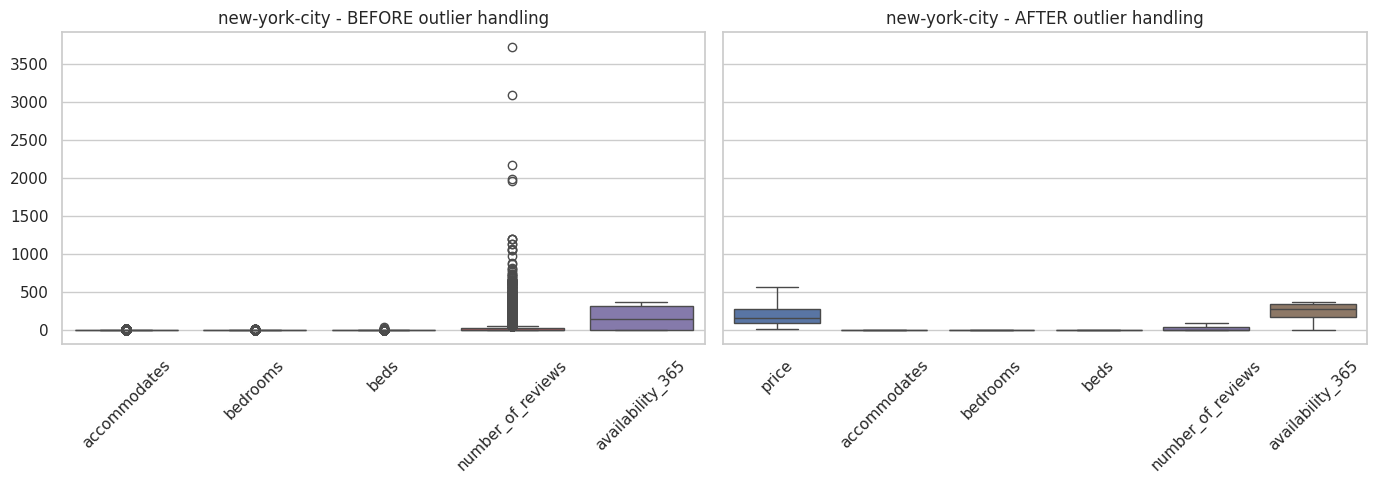

INSPECTION FOR CITY: LOS-ANGELES

 BEFORE PREPROCESSING 

 RAW INSPECTION: LOS-ANGELES 

SHAPE: (45886, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,2708,https://www.airbnb.com/rooms/2708,20250901181307,2025-09-03,city scrape,"Run Runyon, Beaut Furn Mirror Mini-Suit w/ Fir...",Run Runyon Canyon<br /><br />Gym & Sauna <br /...,"Walk and run to Runyon Canyon, it is open!<br ...",https://a0.muscache.com/pictures/hosting/Hosti...,3008,...,4.87,NaN,f,2,0,2,0,0.33,los-angeles,big
1,2732,https://www.airbnb.com/rooms/2732,20250901181307,2025-09-03,city scrape,Zen Life at the Beach,An oasis of tranquility awaits you.,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082993/c5a99...,3041,...,4.22,228269,f,2,1,1,0,0.14,los-angeles,big
2,2864,https://www.airbnb.com/rooms/2864,20250901181307,2025-09-03,previous scrape,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,https://a0.muscache.com/pictures/23817858/de20...,3207,...,NaN,NaN,f,1,1,0,0,NaN,los-angeles,big
3,6033,https://www.airbnb.com/rooms/6033,20250901181307,2025-09-03,previous scrape,Poolside Serenity Studio,Our distinctive bachelor's studio for 1-3 gues...,NaN,https://a0.muscache.com/pictures/458111/986c76...,11619,...,4.29,NaN,f,6,3,3,0,0.10,los-angeles,big
4,6931,https://www.airbnb.com/rooms/6931,20250901181307,2025-09-03,city scrape,"RUN Runyon, Beau Furn Rms Terrace Hollyw Hill ...",Run Runyon Canyon & Views<br /><br />Gym & Sau...,We are in the middle of one of the great citie...,https://a0.muscache.com/pictures/miso/Hosting-...,3008,...,4.76,NaN,t,2,0,2,0,0.19,los-angeles,big



MISSING VALUES (TOP 20):
calendar_updated               45886
license                        33031
neighborhood_overview          25950
neighbourhood                  25949
host_about                     20481
review_scores_value            12516
review_scores_location         12515
review_scores_checkin          12514
review_scores_communication    12509
review_scores_accuracy         12508
review_scores_cleanliness      12508
last_review                    12501
first_review                   12501
review_scores_rating           12501
reviews_per_month              12501
host_location                  10800
host_response_time             10305
host_response_rate             10305
host_acceptance_rate            9999
host_neighbourhood              9575
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,45886.000000,42847.000000,36855.000000,33385.000000,33378.000000,33378.000000,33372.000000,33377.000000,33371.000000,33370.000000,45886.000000,45886.000000,45886.000000,45886.000000
mean,4.049122,1.806428,2.256329,4.778284,4.800412,4.748635,4.855776,4.855556,4.791075,4.705185,38.080177,212.588066,18.935906,439.274288
std,2.872243,1.318635,1.736959,0.428763,0.415376,0.443773,0.374306,0.386141,0.392111,0.456059,84.895224,136.633617,31.297177,388.071327
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.740000,4.780000,4.690000,4.860000,4.870000,4.750000,4.650000,0.000000,84.000000,2.000000,90.000000
50%,3.000000,1.000000,2.000000,4.910000,4.920000,4.880000,4.970000,4.970000,4.910000,4.820000,5.000000,252.000000,30.000000,365.000000
75%,6.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.960000,35.000000,348.000000,30.000000,365.000000
max,16.000000,24.000000,50.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3151.000000,365.000000,1124.000000,3650.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,33550
Private room,11624
Shared room,387
Hotel room,325



neighbourhood_cleansed (266 unique):


,count
neighbourhood_cleansed,
Long Beach,1858
Hollywood,1816
Venice,1540
Santa Monica,1244
West Hollywood,1220



 AFTER PREPROCESSING

 CLEANED INSPECTION: LOS-ANGELES

SHAPE (model df): (36819, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,81.0,1.0,1.0,1.0,1.0,4.87,4.82,4.93,5.00,4.98,...,550.0,2,8,81.0,4.918571,0,91,0.5,0.983714,11.645161
1,110.0,1.0,1.0,1.0,1.0,4.41,4.26,4.58,4.39,4.48,...,27.0,2,17,110.0,4.464286,0,19,0.5,0.892857,34.250000
4,88.0,1.0,1.0,1.0,1.0,4.86,4.85,4.91,4.91,4.91,...,500.0,2,8,88.0,4.844286,0,73,0.5,0.968857,9.387097
5,507.5,2.0,1.0,1.0,1.5,4.89,4.84,5.00,5.00,4.95,...,730.0,2,14,272.5,4.931429,0,22,1.0,0.986286,91.000000
6,81.0,2.0,1.0,2.0,1.0,4.83,4.90,4.82,4.86,4.87,...,240.0,2,14,81.0,4.862857,0,71,1.0,0.972571,10.032258



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,...,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000,36819.000000
mean,199.371873,4.150411,1.668283,2.196067,1.553003,4.814841,4.832505,4.792637,4.882604,4.886027,...,410.452592,0.482767,12.518075,119.254730,4.822636,0.760857,39.719384,1.458919,0.964527,49.801413
std,140.393462,2.762441,1.018733,1.477865,0.808717,0.371726,0.354544,0.372082,0.321585,0.328620,...,358.052145,0.867847,4.226563,65.701221,0.314416,0.426566,18.168507,0.677224,0.062883,56.076280
min,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,3.384615,1.000000,0.000000,0.000000,0.083333,0.200000,0.000000
25%,95.000000,2.000000,1.000000,1.000000,1.000000,4.820000,4.840000,4.790000,4.910000,4.920000,...,120.000000,0.000000,12.000000,70.000000,4.821429,1.000000,26.000000,1.000000,0.964286,8.741935
50%,155.000000,4.000000,1.000000,2.000000,1.000000,4.910000,4.920000,4.890000,4.960000,4.970000,...,365.000000,0.000000,14.000000,101.000000,4.908571,1.000000,40.000000,1.400000,0.981714,11.774194
75%,260.000000,6.000000,2.000000,3.000000,2.000000,4.980000,4.980000,4.960000,5.000000,5.000000,...,365.000000,0.000000,14.000000,151.000000,4.931429,1.000000,52.000000,2.000000,0.986286,87.333333
max,507.500000,12.000000,3.500000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,3650.000000,3.000000,20.000000,272.500000,5.000000,1.000000,91.000000,16.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


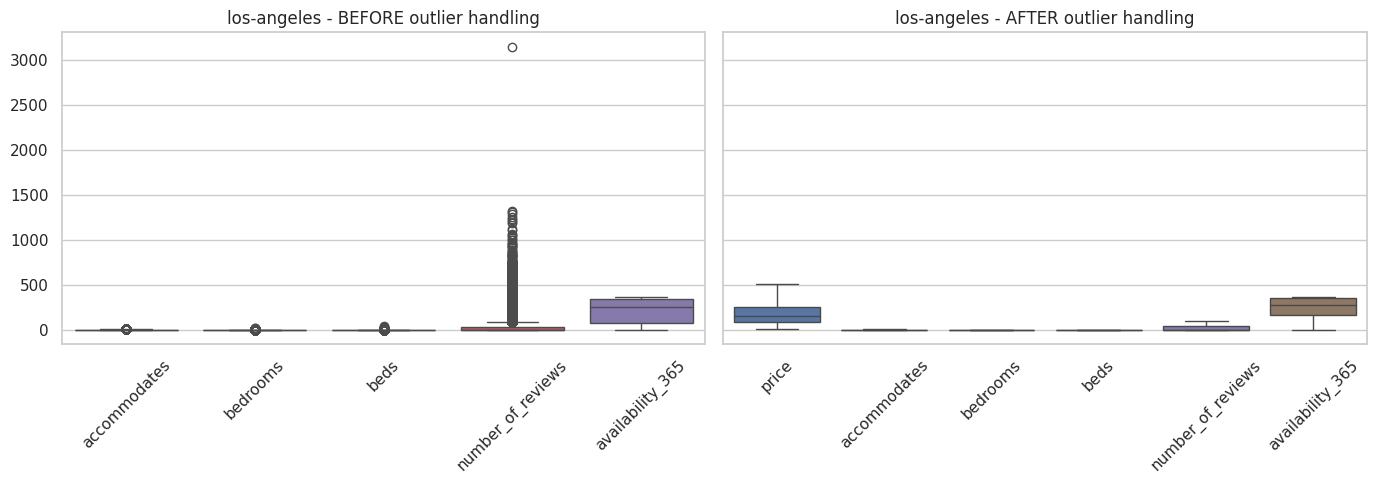

INSPECTION FOR CITY: SAN-FRANCISCO

 BEFORE PREPROCESSING 

 RAW INSPECTION: SAN-FRANCISCO 

SHAPE: (7780, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,958,https://www.airbnb.com/rooms/958,20250901181253,2025-09-01,city scrape,"Bright, Modern Garden Unit - 1BR/1BTH",Our bright garden unit overlooks a lovely back...,Quiet cul de sac in friendly neighborhood<br /...,https://a0.muscache.com/pictures/be1bf5ac-a955...,1169,...,4.78,STR-0006854,f,1,1,0,0,2.53,san-francisco,big
1,5858,https://www.airbnb.com/rooms/5858,20250901181253,2025-09-01,city scrape,Creative Sanctuary,We live in a large Victorian house on a quiet ...,I love how our neighborhood feels quiet but is...,https://a0.muscache.com/pictures/hosting/Hosti...,8904,...,4.68,NaN,f,1,1,0,0,0.53,san-francisco,big
2,8014,https://www.airbnb.com/rooms/8014,20250901181253,2025-09-01,city scrape,female HOST quiet fast internet market parking,Room is on the second floor so it gets a good ...,"The neighborhood is very residential, close to...",https://a0.muscache.com/pictures/2cc1fc3d-0ae0...,22402,...,4.66,STR-0000974,f,3,0,3,0,0.57,san-francisco,big
3,8142,https://www.airbnb.com/rooms/8142,20250901181253,2025-09-01,city scrape,*FriendlyRoom Apt. Style -UCSF/USF - San Franc...,Nice and good public transportation. 7 minute...,"N Juda Muni, Bus and UCSF Shuttle.<br /><br />...",https://a0.muscache.com/pictures/hosting/Hosti...,21994,...,4.70,NaN,f,20,0,20,0,0.07,san-francisco,big
4,8339,https://www.airbnb.com/rooms/8339,20250901181253,2025-09-01,city scrape,Historic Alamo Square Victorian,"For creative humans who love art, space, photo...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,24215,...,4.75,STR-0000264,f,1,1,0,0,0.13,san-francisco,big



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    7780
calendar_updated                7780
neighbourhood                   3097
neighborhood_overview           3097
host_about                      3084
license                         2647
price                           1985
estimated_revenue_l365d         1985
beds                            1958
bathrooms                       1934
review_scores_location          1871
review_scores_value             1871
review_scores_checkin           1871
first_review                    1870
review_scores_rating            1870
review_scores_accuracy          1870
last_review                     1870
review_scores_cleanliness       1870
reviews_per_month               1870
review_scores_communication     1870
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,7780.000000,7291.000000,5822.000000,5910.000000,5910.000000,5910.000000,5909.000000,5910.000000,5909.000000,5909.000000,7780.000000,7780.000000,7780.000000,7780.000000
mean,3.232005,1.432314,1.770354,4.789475,4.810140,4.775068,4.884737,4.865125,4.788201,4.673897,52.701414,189.690746,19.860925,512.296144
std,2.083062,0.983635,1.213221,0.417017,0.420637,0.437412,0.316328,0.349049,0.390806,0.453168,113.273945,132.339903,48.255644,11340.912178
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.760000,4.810000,4.740000,4.900000,4.880000,4.760000,4.620000,1.000000,58.000000,2.000000,30.000000
50%,2.000000,1.000000,1.000000,4.920000,4.930000,4.920000,4.980000,4.980000,4.900000,4.780000,7.000000,214.000000,3.000000,365.000000
75%,4.000000,2.000000,2.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.910000,46.000000,313.000000,30.000000,365.000000
max,16.000000,11.000000,16.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1417.000000,365.000000,1125.000000,999999.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,4677
Private room,2829
Hotel room,240
Shared room,34



neighbourhood_cleansed (37 unique):


,count
neighbourhood_cleansed,
Downtown/Civic Center,1227
South of Market,607
Mission,540
Western Addition,509
Nob Hill,363



 AFTER PREPROCESSING

 CLEANED INSPECTION: SAN-FRANCISCO

SHAPE (model df): (5795, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,157.0,3.0,1.0,2.0,1.00,4.89,4.94,4.93,4.96,4.89,...,30.0,0,20,157.000000,4.910000,1,55,1.500000,0.982000,74.666667
1,250.0,4.0,2.0,2.0,2.00,4.87,4.85,4.87,4.89,4.85,...,90.0,0,1,125.000000,4.825714,1,17,1.333333,0.965143,11.516129
2,67.0,1.0,1.0,1.0,2.00,4.77,4.74,4.30,4.92,4.94,...,60.0,2,14,67.000000,4.702857,0,31,0.500000,0.940571,8.400000
3,56.0,1.0,3.0,1.0,2.25,4.70,4.50,4.50,4.80,4.80,...,90.0,2,6,18.666667,4.671429,0,21,0.250000,0.934286,10.969697
4,527.0,2.0,1.0,1.0,1.50,4.86,4.88,5.00,4.94,5.00,...,91.0,0,20,388.500000,4.910000,1,38,1.000000,0.982000,32.700000



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,...,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000,5795.000000
mean,216.201035,3.132355,1.362726,1.665574,1.247196,4.825736,4.846476,4.813317,4.910138,4.895772,...,546.184987,0.693011,10.730975,157.253755,4.830325,0.649008,36.560656,1.376897,0.966065,47.595758
std,144.680770,1.696587,0.859429,0.901604,0.450739,0.321300,0.311695,0.335230,0.241433,0.274269,...,13137.607948,0.951977,6.118545,93.561103,0.251819,0.477322,15.726221,0.736222,0.050364,54.229303
min,29.000000,1.000000,0.000000,0.000000,0.250000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,6.500000,1.000000,0.000000,0.000000,0.090909,0.200000,0.000000
25%,105.000000,2.000000,1.000000,1.000000,1.000000,4.820000,4.860000,4.800000,4.920000,4.910000,...,30.000000,0.000000,4.000000,86.000000,4.812143,0.000000,24.000000,1.000000,0.962429,7.645161
50%,170.000000,2.000000,1.000000,1.000000,1.000000,4.910000,4.930000,4.910000,4.970000,4.970000,...,365.000000,0.000000,11.000000,130.000000,4.910000,1.000000,36.000000,1.000000,0.982000,11.774194
75%,285.000000,4.000000,2.000000,2.000000,1.500000,4.990000,4.990000,4.980000,5.000000,5.000000,...,365.000000,2.000000,15.000000,207.000000,4.931429,1.000000,48.000000,1.666667,0.986286,85.000000
max,555.000000,7.000000,3.500000,3.500000,2.250000,5.000000,5.000000,5.000000,5.000000,5.000000,...,999999.000000,3.000000,20.000000,388.500000,5.000000,1.000000,84.000000,9.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


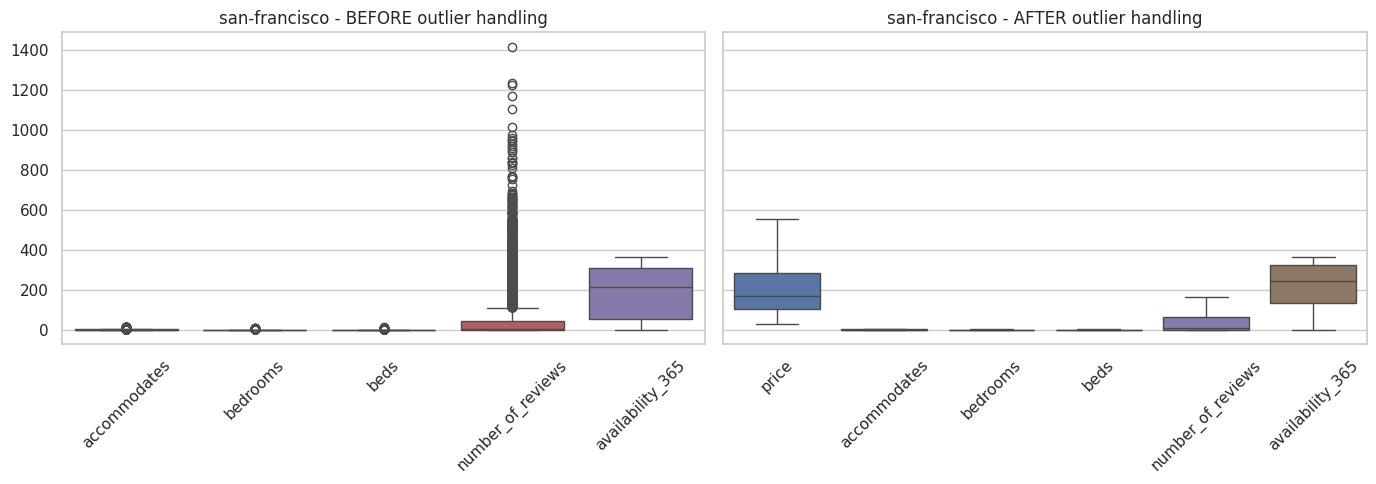

INSPECTION FOR CITY: CHICAGO

 BEFORE PREPROCESSING 

 RAW INSPECTION: CHICAGO 

SHAPE: (8604, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,2384,https://www.airbnb.com/rooms/2384,20250617145442,2025-06-17,city scrape,Hyde Park - Walk to University of Chicago,Solo Hyde Park visitors are welcome to book th...,The apartment is less than one block from beau...,https://a0.muscache.com/pictures/hosting/Hosti...,2613,...,4.94,R17000015609,f,1,0,1,0,1.99,chicago,big
1,7126,https://www.airbnb.com/rooms/7126,20250617145442,2025-06-18,city scrape,Tiny Studio Apartment 94 Walk Score,A very small studio in a wonderful neighborhood.,"Ukrainian Village was just named ""Hottest Neig...",https://a0.muscache.com/pictures/51073/16c81c7...,17928,...,4.76,R24000114046,f,1,1,0,0,2.98,chicago,big
2,10945,https://www.airbnb.com/rooms/10945,20250617145442,2025-06-17,city scrape,The Biddle House (#1),Beautiful first floor apartment in Historic Ol...,NaN,https://a0.muscache.com/pictures/58d1a420-a24b...,33004,...,4.73,2209984,t,7,7,0,0,0.89,chicago,big
3,12140,https://www.airbnb.com/rooms/12140,20250617145442,2025-06-18,city scrape,Lincoln Park Guest House,Bed and Breakfast license issued by the City o...,The Guest House is in the heart of Chicago's m...,https://a0.muscache.com/pictures/miso/Hosting-...,46734,...,4.67,2398451,f,1,0,1,0,0.15,chicago,big
4,28749,https://www.airbnb.com/rooms/28749,20250617145442,2025-06-18,city scrape,Quirky Bucktown Loft w/ Parking No Parties,Located on a peaceful treelined street in ener...,Bucktown is a thriving community on the Northw...,https://a0.muscache.com/pictures/95884ff6-a672...,27506,...,4.72,R24000113825,f,1,1,0,0,1.43,chicago,big



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    8604
calendar_updated                8604
neighborhood_overview           3897
neighbourhood                   3896
host_about                      3152
license                         2697
review_scores_cleanliness       1782
last_review                     1782
first_review                    1782
review_scores_accuracy          1782
review_scores_location          1782
review_scores_communication     1782
reviews_per_month               1782
review_scores_value             1782
review_scores_checkin           1782
review_scores_rating            1782
host_location                   1700
price                            923
estimated_revenue_l365d          923
beds                             896
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,8604.000000,8418.000000,7708.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,8604.000000,8604.000000,8604.000000,8604.000000
mean,4.448629,1.855072,2.362999,4.760796,4.793556,4.761406,4.833134,4.847543,4.753470,4.675233,53.957927,220.577755,13.745932,478.432706
std,3.149576,1.275107,1.943350,0.405797,0.369949,0.392431,0.366143,0.369052,0.377432,0.436090,93.659171,113.877314,24.802441,410.876925
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,4.720000,4.760000,4.710000,4.830000,4.860000,4.690000,4.620000,1.000000,133.000000,2.000000,95.000000
50%,4.000000,2.000000,2.000000,4.870000,4.900000,4.880000,4.930000,4.950000,4.880000,4.790000,14.000000,250.000000,2.000000,365.000000
75%,6.000000,2.000000,3.000000,4.980000,4.990000,4.990000,5.000000,5.000000,4.980000,4.890000,68.000000,320.000000,32.000000,1125.000000
max,16.000000,20.000000,20.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1222.000000,365.000000,365.000000,1125.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,6529
Private room,1900
Hotel room,119
Shared room,56



neighbourhood_cleansed (76 unique):


,count
neighbourhood_cleansed,
Near North Side,1038
West Town,765
Near West Side,628
Lake View,550
Loop,547



 AFTER PREPROCESSING

 CLEANED INSPECTION: CHICAGO

SHAPE (model df): (7681, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,113.0,1.0,1.0,1.0,1.0,4.99,4.98,4.99,4.99,4.98,...,89.0,2,14,113.000000,4.974286,0,50,0.500000,0.994857,85.250000
1,100.0,2.0,1.0,1.0,1.0,4.73,4.86,4.58,4.91,4.88,...,60.0,0,19,100.000000,4.802857,1,41,1.000000,0.960571,20.000000
2,203.0,4.0,2.0,2.0,1.0,4.73,4.83,4.82,4.83,4.88,...,120.0,0,6,101.500000,4.828571,1,49,1.333333,0.965714,56.800000
3,288.0,3.0,1.0,1.0,1.0,4.94,4.67,5.00,5.00,5.00,...,10.0,2,6,288.000000,4.897143,0,27,1.500000,0.979429,49.000000
4,250.0,7.0,3.0,3.0,2.0,4.82,4.87,4.76,4.94,4.88,...,10.0,0,7,83.333333,4.845714,1,60,1.750000,0.969143,26.666667



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,...,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000,7681.000000
mean,212.857375,4.387319,1.732392,2.246973,1.410819,4.786267,4.819758,4.789609,4.854907,4.869869,...,478.810311,0.450462,11.083713,127.815985,4.800546,0.773076,41.354251,1.517461,0.960109,57.317083
std,149.014900,2.867806,0.964148,1.498197,0.675936,0.359971,0.322026,0.349297,0.327108,0.332447,...,410.548888,0.841734,5.057188,85.959521,0.291354,0.418870,15.827838,0.698847,0.058271,52.514760
min,13.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,0.000000,0.000000,7.800000,1.000000,0.000000,2.000000,0.166667,0.200000,0.000000
25%,99.000000,2.000000,1.000000,1.000000,1.000000,4.770000,4.810000,4.770000,4.870000,4.890000,...,95.000000,0.000000,7.000000,63.000000,4.785714,1.000000,32.000000,1.000000,0.957143,9.454545
50%,169.000000,4.000000,2.000000,2.000000,1.000000,4.870000,4.900000,4.880000,4.930000,4.950000,...,365.000000,0.000000,12.000000,99.000000,4.885714,1.000000,41.000000,1.500000,0.977143,45.333333
75%,286.000000,6.000000,2.000000,3.000000,2.000000,4.950000,4.960000,4.960000,4.980000,5.000000,...,1125.000000,0.000000,14.000000,169.000000,4.915714,1.000000,52.000000,2.000000,0.983143,100.000000
max,566.500000,12.000000,3.500000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1125.000000,3.000000,20.000000,328.000000,5.000000,1.000000,82.000000,15.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


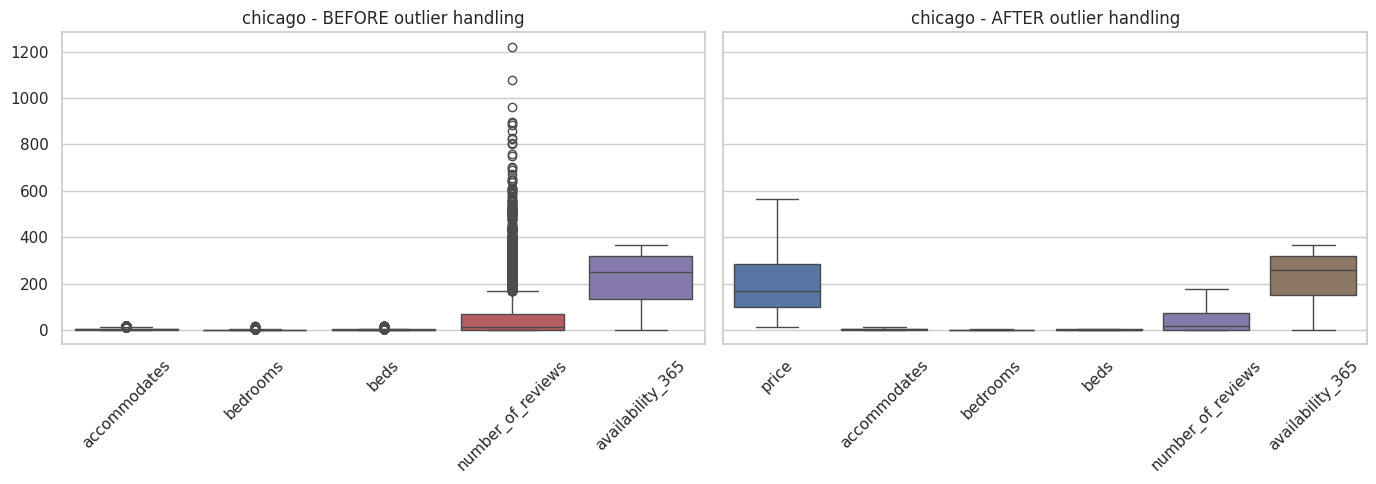

INSPECTION FOR CITY: AUSTIN

 BEFORE PREPROCESSING 

 RAW INSPECTION: AUSTIN 

SHAPE: (15187, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,5456,https://www.airbnb.com/rooms/5456,20250613040113,2025-06-13,city scrape,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,My neighborhood is ideally located if you want...,https://a0.muscache.com/pictures/14084884/b5a3...,8028,...,4.79,NaN,f,1,1,0,0,3.59,austin,medium
1,5769,https://www.airbnb.com/rooms/5769,20250613040113,2025-06-13,city scrape,NW Austin Room,NaN,Quiet neighborhood with lots of trees and good...,https://a0.muscache.com/pictures/23822033/ac94...,8186,...,4.92,NaN,f,1,0,1,0,1.65,austin,medium
2,6413,https://www.airbnb.com/rooms/6413,20250613040113,2025-06-14,previous scrape,Gem of a Studio near Downtown,"Great studio apartment, perfect a single perso...",Travis Heights is one of the oldest neighborho...,https://a0.muscache.com/pictures/hosting/Hosti...,13879,...,4.93,NaN,f,1,1,0,0,0.65,austin,medium
3,6448,https://www.airbnb.com/rooms/6448,20250613040113,2025-06-13,city scrape,"Secluded Studio @ Zilker - King Bed, Bright & ...","Clean, private space with everything you need ...",The neighborhood is fun and funky (but quiet)!...,https://a0.muscache.com/pictures/airflow/Hosti...,14156,...,4.88,NaN,t,1,1,0,0,2.02,austin,medium
4,8502,https://www.airbnb.com/rooms/8502,20250613040113,2025-06-13,city scrape,Woodland Studio Lodging,Studio rental on lower level of home located i...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,25298,...,4.63,NaN,f,1,1,0,0,0.29,austin,medium



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    15187
calendar_updated                15187
license                         15187
neighbourhood                    7273
neighborhood_overview            7273
host_about                       5836
beds                             4491
estimated_revenue_l365d          4479
price                            4479
bathrooms                        4473
host_response_time               4319
host_response_rate               4319
host_acceptance_rate             3499
review_scores_location           2913
review_scores_value              2913
review_scores_checkin            2912
last_review                      2911
review_scores_cleanliness        2911
review_scores_accuracy           2911
reviews_per_month                2911
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,15187.000000,14248.000000,10696.000000,12276.000000,12276.000000,12276.000000,12275.000000,12276.000000,12274.000000,12274.000000,15187.000000,15187.000000,15187.000000,15187.000000
mean,5.008560,2.095101,2.972046,4.832434,4.851587,4.807500,4.893805,4.897551,4.820204,4.772874,44.177454,174.443010,7.888984,461.863172
std,3.426457,1.441938,2.981831,0.343546,0.338384,0.362994,0.296193,0.301599,0.323714,0.370725,91.255975,140.900826,30.206797,432.045884
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.800000,4.840000,4.770000,4.900000,4.910000,4.780000,4.730000,1.000000,0.000000,1.000000,60.000000
50%,4.000000,2.000000,2.000000,4.940000,4.950000,4.920000,4.980000,4.990000,4.910000,4.860000,10.000000,177.000000,2.000000,365.000000
75%,6.000000,3.000000,4.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,46.000000,323.000000,3.000000,1125.000000
max,16.000000,23.000000,132.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1291.000000,365.000000,1124.000000,1825.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,12326
Private room,2604
Hotel room,172
Shared room,85



neighbourhood_cleansed (44 unique):


,count
neighbourhood_cleansed,
78704,2284
78702,1773
78701,1246
78741,859
78745,834



 AFTER PREPROCESSING

 CLEANED INSPECTION: AUSTIN

SHAPE (model df): (10708, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,101.0,3.0,1.0,2.0,1.0,4.85,4.88,4.86,4.90,4.82,...,90.0,0,1,101.0,4.832857,1,30.0,1.5,0.966571,112.000000
1,45.0,2.0,1.0,1.0,1.0,4.91,4.91,4.87,4.91,4.94,...,14.0,2,20,45.0,4.890000,0,38.0,1.0,0.978000,2.000000
3,155.0,2.0,1.0,2.0,1.0,4.97,4.97,4.96,4.99,4.98,...,365.0,0,3,155.0,4.960000,1,61.0,1.0,0.992000,78.000000
4,43.0,2.0,1.0,1.0,1.0,4.57,4.55,4.67,4.85,4.88,...,90.0,0,11,43.0,4.691429,1,12.0,1.0,0.938286,19.600000
5,145.0,3.0,2.0,2.0,2.0,5.00,4.94,4.94,5.00,5.00,...,150.0,0,1,72.5,4.974286,1,55.0,1.0,0.994857,9.709677



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,...,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000,10708.000000
mean,180.701065,5.098711,2.084610,2.801784,1.673515,4.853253,4.868843,4.830976,4.906550,4.911623,...,435.077419,0.294453,9.149701,94.231710,4.855951,0.853941,44.771526,1.657049,0.971190,77.162002
std,124.896697,3.124434,1.382736,2.046212,0.816017,0.285330,0.282749,0.304831,0.248286,0.251759,...,397.245633,0.719356,7.262333,52.530185,0.238180,0.353182,17.845948,0.772285,0.047636,58.506647
min,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,2.000000,1.000000,0.000000,0.000000,0.166667,0.200000,0.000000
25%,89.000000,2.000000,1.000000,1.000000,1.000000,4.830000,4.860000,4.800000,4.920000,4.920000,...,90.000000,0.000000,3.000000,55.000000,4.841429,1.000000,33.000000,1.000000,0.968286,19.958333
50%,138.000000,4.000000,2.000000,2.000000,1.000000,4.930000,4.940000,4.910000,4.970000,4.980000,...,365.000000,0.000000,8.000000,79.000000,4.925714,1.000000,46.000000,1.500000,0.985143,74.000000
75%,235.000000,6.000000,3.000000,4.000000,2.000000,5.000000,5.000000,4.990000,5.000000,5.000000,...,365.000000,0.000000,16.000000,119.000000,4.952857,1.000000,58.000000,2.000000,0.990571,119.333333
max,454.000000,12.000000,6.000000,8.500000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1825.000000,3.000000,20.000000,215.000000,5.000000,1.000000,95.500000,16.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


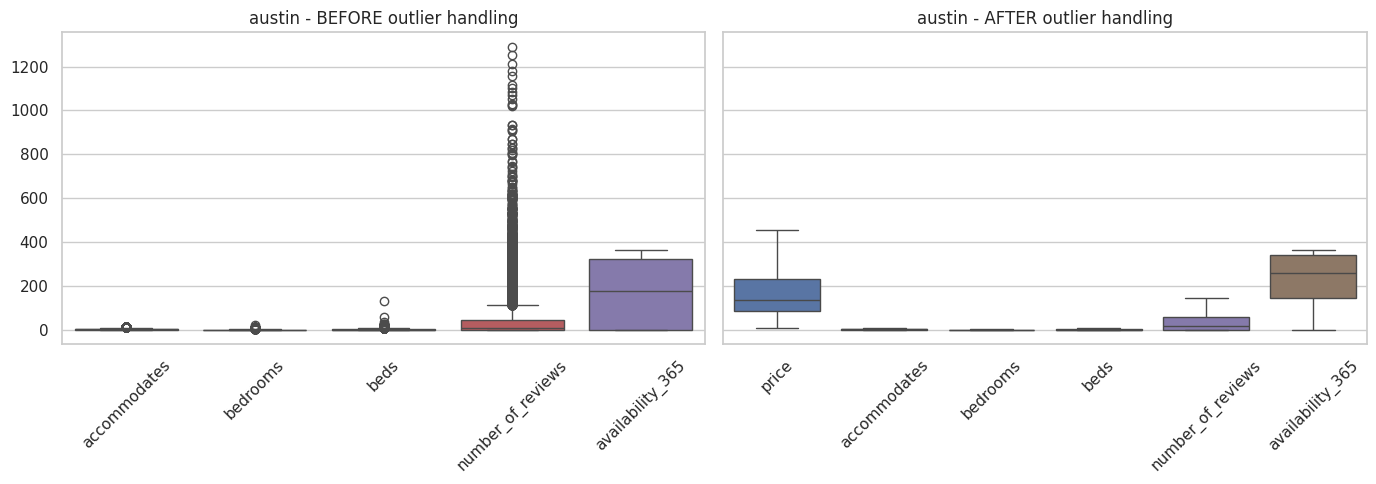

INSPECTION FOR CITY: SEATTLE

 BEFORE PREPROCESSING 

 RAW INSPECTION: SEATTLE 

SHAPE: (6996, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,6606,https://www.airbnb.com/rooms/6606,20250925032813,2025-09-25,city scrape,"Fab, private seattle urban cottage!","This tiny cottage is only 15x10, but it has ev...","A peaceful yet highly accessible neighborhood,...",https://a0.muscache.com/pictures/45742/21116d7...,14942,...,4.57,str-opli-19-002622,f,3,3,0,0,0.82,seattle,medium
1,9419,https://www.airbnb.com/rooms/9419,20250925032813,2025-09-25,city scrape,Glorious sun room w/ memory foambed,This beautiful double room features sun filled...,"Lots of restaurants (see our guide book) bars,...",https://a0.muscache.com/pictures/56645186/e5fb...,30559,...,4.69,Exempt,f,10,0,10,0,1.19,seattle,medium
2,9596,https://www.airbnb.com/rooms/9596,20250925032813,2025-09-25,previous scrape,"the down home , spacious, central and fab!","We are in a great neighborhood, quiet, full of...","if you arrive early for check in at 3, I reco...",https://a0.muscache.com/pictures/665252/102d18...,14942,...,4.56,STR -OPLI-19-002622,f,3,3,0,0,0.56,seattle,medium
3,11012,https://www.airbnb.com/rooms/11012,20250925032813,2025-09-25,city scrape,"the orange house, quiet 'n central",NaN,NaN,https://a0.muscache.com/pictures/682034/54bc27...,14942,...,4.74,str-opli-19-002622,f,3,3,0,0,0.51,seattle,medium
4,25002,https://www.airbnb.com/rooms/25002,20250925032813,2025-09-25,city scrape,Beautiful Private Spot in North Ballard,"-Great eating , Delancey, Fat Hen, 3 blocks aw...",Great walking neighborhood! We are in between...,https://a0.muscache.com/pictures/491561/cf5270...,102684,...,4.90,STR-OPLI-19-002617,t,1,1,0,0,6.06,seattle,medium



MISSING VALUES (TOP 20):
calendar_updated               6996
neighbourhood                  2820
neighborhood_overview          2820
host_about                     2431
host_location                  1422
license                        1211
host_response_time             1069
host_response_rate             1069
review_scores_value             887
review_scores_accuracy          887
review_scores_cleanliness       887
review_scores_communication     887
reviews_per_month               887
review_scores_rating            887
review_scores_location          887
last_review                     887
review_scores_checkin           887
first_review                    887
host_acceptance_rate            884
price                           775
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,6996.000000,6845.000000,6285.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6109.000000,6996.000000,6996.000000,6996.000000,6996.000000
mean,4.010292,1.661066,2.157677,4.808836,4.837687,4.816284,4.879180,4.883393,4.834426,4.717764,82.307604,207.709405,10.990709,389.699257
std,2.595572,1.182109,1.519486,0.338030,0.301480,0.334917,0.255026,0.290954,0.262944,0.357484,126.641425,122.928557,18.718235,429.112014
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.780000,4.820000,4.780000,4.870000,4.890000,4.800000,4.670000,5.000000,90.000000,1.000000,30.000000
50%,4.000000,1.000000,2.000000,4.900000,4.920000,4.910000,4.950000,4.970000,4.900000,4.810000,32.000000,234.000000,2.000000,365.000000
75%,5.000000,2.000000,3.000000,4.980000,4.980000,4.980000,5.000000,5.000000,4.970000,4.900000,105.000000,327.000000,30.000000,365.000000
max,16.000000,13.000000,15.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1577.000000,365.000000,365.000000,10000.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,5745
Private room,1175
Hotel room,51
Shared room,25



neighbourhood_cleansed (88 unique):


,count
neighbourhood_cleansed,
Belltown,380
Broadway,375
University District,287
Wallingford,279
Minor,258



 AFTER PREPROCESSING

 CLEANED INSPECTION: SEATTLE

SHAPE (model df): (6221, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,99.0,1.0,1.0,1.0,1.0,4.60,4.67,4.67,4.83,4.77,...,1125.0,0,19,99.000000,4.712857,1,29,0.5,0.942571,5.709677
1,71.0,2.0,1.0,2.0,3.0,4.73,4.80,4.75,4.92,4.89,...,90.0,2,16,71.000000,4.782857,0,55,1.0,0.956571,109.000000
3,311.0,8.0,3.0,3.0,2.0,4.79,4.82,4.61,4.78,4.72,...,120.0,0,19,103.666667,4.760000,1,41,2.0,0.952000,5.741935
4,88.0,4.0,1.0,2.0,1.0,4.93,4.92,4.91,4.98,4.98,...,30.0,0,16,88.000000,4.931429,1,44,2.0,0.986286,73.666667
5,154.0,3.0,2.0,3.0,1.0,4.54,4.72,4.57,4.46,4.58,...,730.0,0,7,77.000000,4.580000,1,37,1.0,0.916000,11.741935



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,...,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000,6221.000000
mean,168.444060,4.005465,1.567272,2.117987,1.436907,4.820510,4.847475,4.826763,4.889003,4.896602,...,391.395113,0.339174,12.504099,108.923495,4.836101,0.828484,44.442212,1.507453,0.967220,60.260179
std,87.151142,2.465968,0.968192,1.342802,0.695355,0.309417,0.281765,0.309166,0.227134,0.255915,...,430.298205,0.753165,5.546111,48.524991,0.238295,0.376989,15.333372,0.602861,0.047659,54.363220
min,15.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,6.666667,1.000000,0.000000,1.000000,0.142857,0.200000,0.000000
25%,105.000000,2.000000,1.000000,1.000000,1.000000,4.800000,4.840000,4.810000,4.880000,4.910000,...,30.000000,0.000000,8.000000,72.500000,4.820000,1.000000,33.000000,1.000000,0.964000,10.857143
50%,149.000000,4.000000,1.000000,2.000000,1.000000,4.900000,4.920000,4.910000,4.950000,4.970000,...,365.000000,0.000000,16.000000,99.000000,4.907143,1.000000,45.000000,1.500000,0.981429,43.666667
75%,212.000000,6.000000,2.000000,3.000000,2.000000,4.970000,4.970000,4.970000,4.990000,5.000000,...,365.000000,0.000000,16.000000,135.000000,4.942857,1.000000,55.000000,2.000000,0.988571,104.333333
max,372.500000,12.000000,3.500000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,10000.000000,3.000000,20.000000,228.750000,5.000000,1.000000,88.000000,8.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


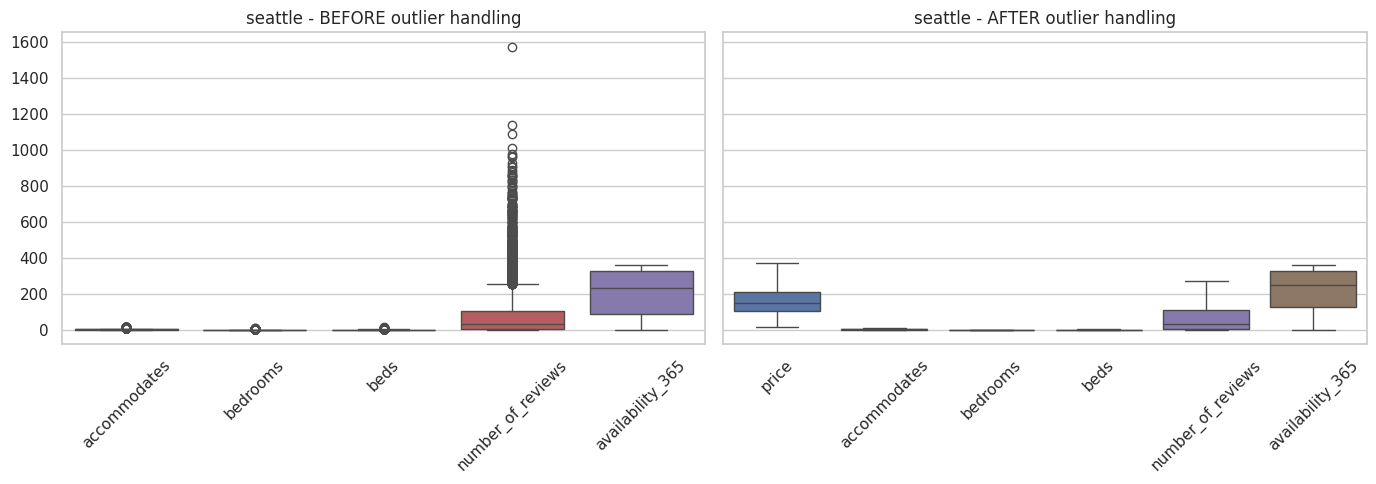

INSPECTION FOR CITY: DENVER

 BEFORE PREPROCESSING 

 RAW INSPECTION: DENVER 

SHAPE: (4910, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,360,https://www.airbnb.com/rooms/360,20250929230429,2025-09-30,city scrape,Denver’s Peaceful Oasis for Travel Nurses & No...,Enjoy the famous Colorado weather and unplug i...,The cottage is located in the center of Lower ...,https://a0.muscache.com/pictures/monet/Select-...,666,...,4.90,2017-BFN-0002177,f,2,2,0,0,2.14,denver,medium
1,364,https://www.airbnb.com/rooms/364,20250929230429,2025-09-30,city scrape,Lodo / RiNo LOFT via airport train,"Modern 1,000 square foot loft in the heart of ...","Ten brewpubs within walking distance, two grea...",https://a0.muscache.com/pictures/11766413/a2c5...,783,...,4.71,NaN,f,1,1,0,0,0.44,denver,medium
2,592,https://www.airbnb.com/rooms/592,20250929230429,2025-09-30,city scrape,private,This room is in the basement. It does not hav...,NaN,https://a0.muscache.com/pictures/ba522ff9-84c9...,933,...,4.88,2021-BFN-0000578,f,1,0,1,0,0.99,denver,medium
3,686,https://www.airbnb.com/rooms/686,20250929230429,2025-09-30,city scrape,Alexandra's Queen Bed Room Long-term Rental Only,Thanks for visiting my Queen Bed Room for LONG...,"I love my Uptown neighborhood, which is within...",https://a0.muscache.com/pictures/108112/e6d5d3...,990,...,4.82,NaN,f,1,0,1,0,1.21,denver,medium
4,1940,https://www.airbnb.com/rooms/1940,20250929230429,2025-09-29,city scrape,Baker Studio: Private-full kitchen-W/D-walkable,Private studio with separate entrance in histo...,Walking through the Baker historical neighborh...,https://a0.muscache.com/pictures/miso/Hosting-...,2150,...,4.90,2018-BFN-0002596,f,2,2,0,0,2.31,denver,medium



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    4910
calendar_updated                4910
neighbourhood                   2172
neighborhood_overview           2172
host_about                      1940
license                         1738
host_response_time               722
host_response_rate               722
host_location                    675
beds                             611
estimated_revenue_l365d          609
price                            609
bathrooms                        608
review_scores_accuracy           608
review_scores_cleanliness        608
review_scores_rating             608
last_review                      608
review_scores_checkin            608
reviews_per_month                608
review_scores_location           608
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,4910.000000,4828.000000,4299.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4302.000000,4910.000000,4910.000000,4910.000000,4910.000000
mean,4.148676,1.809859,2.257967,4.862480,4.879147,4.843570,4.914433,4.912487,4.851492,4.781825,71.723422,211.772301,17.215479,429.468228
std,2.656296,1.126130,1.679740,0.278913,0.261971,0.308679,0.228211,0.257803,0.267801,0.316445,123.461776,125.410379,23.715363,407.667577
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.840000,4.860000,4.820000,4.910000,4.920000,4.810000,4.740000,4.000000,91.000000,2.000000,60.000000
50%,4.000000,2.000000,2.000000,4.940000,4.950000,4.930000,4.970000,4.980000,4.920000,4.860000,23.000000,242.000000,4.000000,365.000000
75%,6.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.940000,87.000000,332.000000,29.000000,730.000000
max,16.000000,10.000000,18.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1711.000000,365.000000,500.000000,1125.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,4164
Private room,673
Shared room,49
Hotel room,24



neighbourhood_cleansed (78 unique):


,count
neighbourhood_cleansed,
Five Points,414
Highland,272
Union Station,212
West Colfax,207
Gateway - Green Valley Ranch,193



 AFTER PREPROCESSING

 CLEANED INSPECTION: DENVER

SHAPE (model df): (4301, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,139.0,2.0,2.0,2.0,1.0,4.98,4.97,4.95,4.99,4.99,...,364.0,0,9,69.5,4.965714,1,52,0.666667,0.993143,4.000000
1,213.0,3.0,1.0,1.0,1.5,4.85,4.78,4.81,4.95,4.96,...,365.0,0,7,193.0,4.815714,1,21,1.500000,0.963143,1.924731
2,46.0,2.0,1.0,1.0,1.0,4.89,4.80,4.61,4.95,4.95,...,365.0,2,12,46.0,4.845714,0,33,1.000000,0.969143,77.333333
3,40.0,1.0,1.0,2.0,1.0,4.77,4.75,4.80,4.86,4.91,...,120.0,2,12,40.0,4.825714,0,35,0.500000,0.965143,5.290323
4,87.0,2.0,0.0,1.0,1.0,4.97,4.96,4.98,4.98,4.98,...,29.0,0,0,87.0,4.951429,1,59,2.000000,0.990286,174.000000



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,...,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000,4301.000000
mean,147.017670,4.017554,1.705650,2.180656,1.492444,4.872013,4.886929,4.856266,4.920963,4.922583,...,432.156940,0.304115,10.570565,89.634757,4.872781,0.852127,44.430598,1.440648,0.974556,50.432271
std,82.938462,2.288339,0.927907,1.376601,0.757291,0.260120,0.245762,0.286222,0.213847,0.236562,...,407.165385,0.738669,4.887141,42.017657,0.218714,0.355015,16.271294,0.572889,0.043743,57.123251
min,8.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.000000,0.000000,0.000000,2.000000,1.000000,0.000000,1.000000,0.200000,0.200000,0.000000
25%,87.000000,2.000000,1.000000,1.000000,1.000000,4.860000,4.880000,4.840000,4.930000,4.930000,...,60.000000,0.000000,7.000000,58.000000,4.857143,1.000000,34.000000,1.000000,0.971429,8.333333
50%,123.000000,4.000000,1.000000,2.000000,1.000000,4.940000,4.940000,4.930000,4.970000,4.980000,...,365.000000,0.000000,12.000000,81.000000,4.928571,1.000000,46.000000,1.333333,0.985714,12.166667
75%,187.000000,5.000000,2.000000,3.000000,2.000000,4.990000,5.000000,4.990000,5.000000,5.000000,...,730.000000,0.000000,12.000000,112.000000,4.954286,1.000000,56.000000,1.800000,0.990857,86.333333
max,337.000000,9.500000,3.500000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1125.000000,3.000000,20.000000,193.000000,5.000000,1.000000,89.000000,8.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


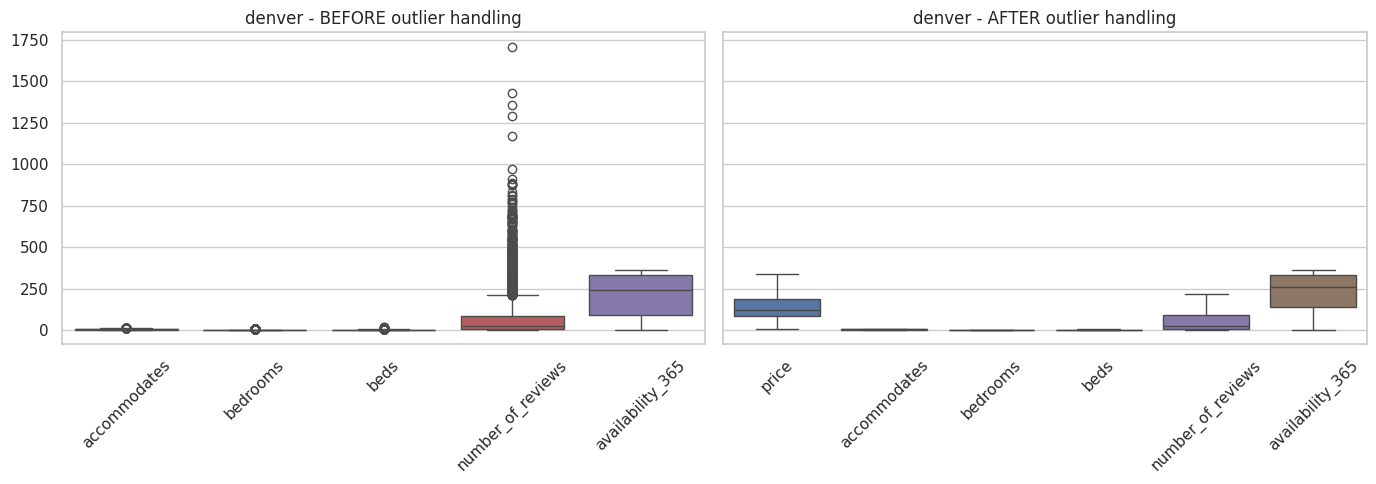

INSPECTION FOR CITY: PORTLAND

 BEFORE PREPROCESSING 

 RAW INSPECTION: PORTLAND 

SHAPE: (4425, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,37676,https://www.airbnb.com/rooms/37676,20250906174546,2025-09-07,city scrape,Mt. Hood View in the Pearl District,"This rare and relaxing 1,000 SF loft is locate...",The Pearl district enjoys a walkability score ...,https://a0.muscache.com/pictures/212298/16fb6b...,162158,...,4.69,NaN,f,1,1,0,0,0.73,portland,medium
1,61893,https://www.airbnb.com/rooms/61893,20250906174546,2025-09-07,city scrape,Perfect Portland Place,Amazing for a long stay in<br />Portland's per...,"Restaurants, bars, shops, and culture of <br /...",https://a0.muscache.com/pictures/miso/Hosting-...,300391,...,4.92,NaN,f,1,1,0,0,0.23,portland,medium
2,67036,https://www.airbnb.com/rooms/67036,20250906174546,2025-09-07,city scrape,Historic Home Located in Central City,"Welcome to Multnomah House, a classic Portland...",Sullivan's Gulch is a central east side neighb...,https://a0.muscache.com/pictures/miso/Hosting-...,329777,...,4.82,12-123170-000-00-LU,f,1,1,0,0,0.45,portland,medium
3,77522,https://www.airbnb.com/rooms/77522,20250906174546,2025-09-06,city scrape,Spacious Suite in Eastmoreland/SE. Hot Tub Dog...,Our private spacious suite is in a beautiful r...,Our neighborhood is very quiet and subdued wit...,https://a0.muscache.com/pictures/miso/Hosting-...,345461,...,4.86,14-227531-000-00-HO,f,1,1,0,0,0.83,portland,medium
4,93613,https://www.airbnb.com/rooms/93613,20250906174546,2025-09-06,city scrape,Sunny Queen Room in FUN Alberta Arts,Peaceful home in vibrant Alberta Arts neighbor...,NaN,https://a0.muscache.com/pictures/d8e34f6a-be4d...,501715,...,4.46,NaN,f,10,3,7,0,0.40,portland,medium



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    4425
calendar_updated                4425
neighbourhood                   1507
neighborhood_overview           1507
host_about                      1465
license                         1407
host_response_time               677
host_response_rate               677
host_location                    655
estimated_revenue_l365d          627
price                            627
bathrooms                        599
beds                             599
review_scores_accuracy           587
review_scores_cleanliness        587
review_scores_rating             587
last_review                      587
review_scores_checkin            587
reviews_per_month                587
review_scores_location           587
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,4425.000000,4300.000000,3826.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,3838.000000,4425.000000,4425.000000,4425.000000,4425.000000
mean,3.619435,1.514186,1.946681,4.861832,4.879646,4.853051,4.920946,4.917793,4.853549,4.794776,109.522260,214.259887,14.028475,376.064181
std,2.206923,1.065011,1.415611,0.265132,0.260983,0.273148,0.243848,0.248364,0.257320,0.289903,169.578949,126.977619,21.910204,396.789579
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.830000,4.870000,4.830000,4.930000,4.930000,4.830000,4.750000,4.000000,97.000000,1.000000,30.000000
50%,3.000000,1.000000,2.000000,4.930000,4.950000,4.930000,4.970000,4.970000,4.920000,4.860000,36.000000,244.000000,2.000000,365.000000
75%,4.000000,2.000000,2.000000,4.990000,4.990000,4.990000,5.000000,5.000000,4.980000,4.930000,139.000000,335.000000,30.000000,365.000000
max,16.000000,9.000000,17.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1813.000000,365.000000,730.000000,1125.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,3733
Private room,622
Hotel room,67
Shared room,3



neighbourhood_cleansed (92 unique):


,count
neighbourhood_cleansed,
Northwest District,247
Richmond,215
Portland Downtown,206
Buckman,178
Concordia,145



 AFTER PREPROCESSING

 CLEANED INSPECTION: PORTLAND

SHAPE (model df): (3798, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,159.0,2.0,1.0,1.0,1.0,4.89,4.87,4.87,4.84,4.79,...,730.0,0,15,159.0,4.842857,1,60,1.0,0.968571,10.935484
1,130.0,2.0,1.0,1.0,1.0,5.00,5.00,5.00,4.92,5.00,...,300.0,0,12,130.0,4.977143,1,55,1.0,0.995429,6.903226
2,284.5,7.0,3.5,3.5,2.0,4.92,4.94,4.99,4.95,4.97,...,365.0,0,12,88.5,4.911429,1,49,2.0,0.982286,63.400000
3,76.0,3.0,1.0,2.0,1.0,4.84,4.82,4.79,4.95,4.95,...,365.0,0,12,76.0,4.884286,1,76,1.5,0.976857,11.645161
4,81.0,1.0,1.0,1.0,4.0,4.52,4.58,4.36,4.83,4.73,...,180.0,2,12,81.0,4.617143,0,38,0.5,0.923429,10.806452



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,...,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000,3798.000000
mean,131.698920,3.455240,1.432991,1.781596,1.299763,4.871343,4.889853,4.864408,4.927720,4.924516,...,378.769352,0.269089,10.809900,91.674933,4.877867,0.857557,42.955766,1.474039,0.975573,64.135348
std,68.501134,1.629648,0.884969,0.915452,0.635606,0.251063,0.244283,0.252445,0.224443,0.237750,...,395.650181,0.671672,4.898354,37.946582,0.210440,0.349550,14.990178,0.583315,0.042088,62.253853
min,17.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,6.000000,1.000000,0.000000,3.000000,0.166667,0.200000,0.000000
25%,82.000000,2.000000,1.000000,1.000000,1.000000,4.860000,4.890000,4.850000,4.940000,4.940000,...,30.000000,0.000000,8.000000,64.000000,4.864286,1.000000,33.000000,1.000000,0.972857,9.290323
50%,110.000000,3.000000,1.000000,2.000000,1.000000,4.930000,4.950000,4.930000,4.970000,4.970000,...,365.000000,0.000000,12.000000,85.000000,4.934286,1.000000,44.000000,1.333333,0.986857,41.900000
75%,163.000000,4.000000,2.000000,2.000000,1.000000,4.980000,4.980000,4.980000,5.000000,5.000000,...,365.000000,0.000000,12.000000,112.000000,4.954286,1.000000,53.000000,2.000000,0.990857,112.000000
max,284.500000,7.000000,3.500000,3.500000,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1125.000000,3.000000,20.000000,184.000000,5.000000,1.000000,83.000000,6.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


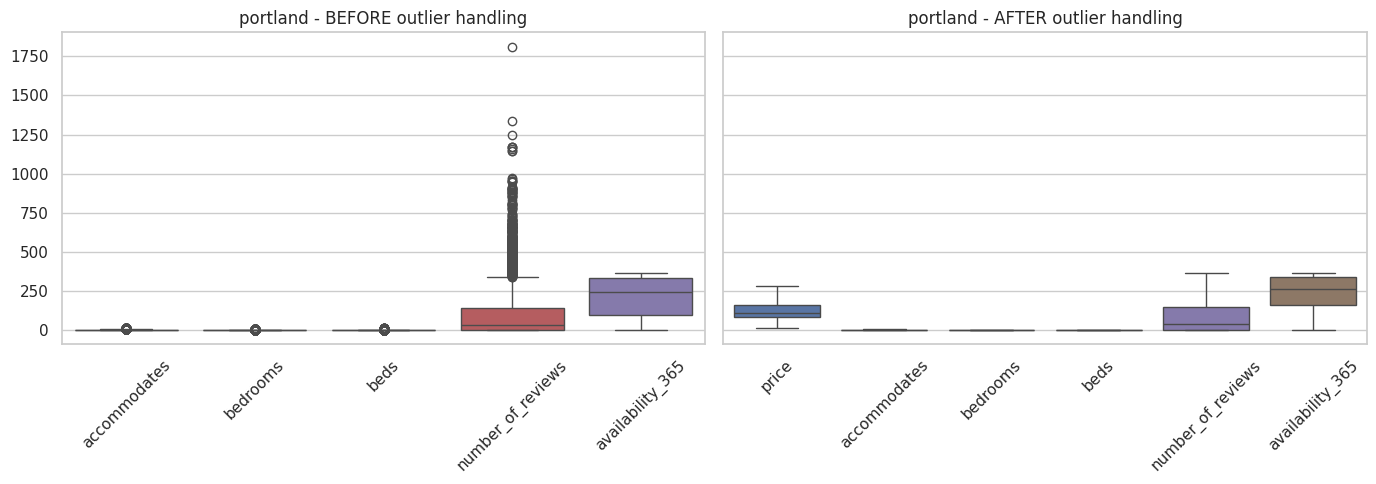

INSPECTION FOR CITY: ASHEVILLE

 BEFORE PREPROCESSING 

 RAW INSPECTION: ASHEVILLE 

SHAPE: (2876, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,155305,https://www.airbnb.com/rooms/155305,20250617145515,2025-06-17,city scrape,Cottage! BonPaul + Sharky's Hostel,West Asheville Cottage within walking distance...,"We are within easy walk of pubs, breweries, mu...",https://a0.muscache.com/pictures/hosting/Hosti...,746673,...,4.58,NaN,t,8,2,3,3,2.69,asheville,small
1,197263,https://www.airbnb.com/rooms/197263,20250617145515,2025-06-17,city scrape,Tranquil Room & Private Bath,"This is a comfy, peaceful and clean room with ...",NaN,https://a0.muscache.com/pictures/miso/Hosting-...,961396,...,4.98,NaN,f,2,1,1,0,0.56,asheville,small
2,209068,https://www.airbnb.com/rooms/209068,20250617145515,2025-06-17,city scrape,Terrace Cottage,Located in one of Asheville's oldest historic ...,Our beautiful Grove Park Historic District clo...,https://a0.muscache.com/pictures/1829924/9f3bf...,1029919,...,4.80,NaN,f,1,1,0,0,0.40,asheville,small
3,246315,https://www.airbnb.com/rooms/246315,20250617145515,2025-06-17,city scrape,Asheville Dreamer's Cabin,"Hi there,<br />I am usually here half of each ...",NaN,https://a0.muscache.com/pictures/5908617/cfe79...,1292070,...,4.59,NaN,f,3,2,1,0,0.32,asheville,small
4,314540,https://www.airbnb.com/rooms/314540,20250617145515,2025-06-17,city scrape,Asheville Urban Farmhouse Entire Home 4.6 mi t...,Farmhouse in the city is OPEN! This charming 1...,City vibes with country appeal. Peaceful neigh...,https://a0.muscache.com/pictures/hosting/Hosti...,381660,...,4.94,NaN,t,1,1,0,0,0.22,asheville,small



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    2876
calendar_updated                2876
license                         2876
host_neighbourhood              1792
host_about                      1025
neighborhood_overview            952
neighbourhood                    952
host_response_rate               442
host_response_time               442
host_location                    440
estimated_revenue_l365d          340
price                            340
beds                             339
bathrooms                        331
review_scores_accuracy           263
last_review                      263
review_scores_cleanliness        263
review_scores_checkin            263
review_scores_communication      263
reviews_per_month                263
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,2876.000000,2842.000000,2537.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2613.000000,2876.000000,2876.000000,2876.000000,2876.000000
mean,4.926982,2.074595,2.756011,4.896070,4.913108,4.903620,4.945377,4.939499,4.880704,4.829923,110.761127,224.535814,5.907510,414.535118
std,3.295566,1.566117,2.381412,0.205561,0.186292,0.182144,0.147369,0.170931,0.179211,0.218828,154.427509,117.150875,18.060935,423.417402
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.870000,4.900000,4.880000,4.940000,4.930000,4.840000,4.780000,10.000000,137.000000,1.000000,30.000000
50%,4.000000,2.000000,2.000000,4.950000,4.960000,4.960000,4.980000,4.980000,4.920000,4.880000,53.000000,254.000000,2.000000,365.000000
75%,6.000000,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.970000,4.940000,144.000000,331.000000,2.000000,730.000000
max,16.000000,38.000000,50.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1448.000000,365.000000,730.000000,1125.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,2571
Private room,285
Hotel room,12
Shared room,8



neighbourhood_cleansed (8 unique):


,count
neighbourhood_cleansed,
28806,807
28801,594
28803,455
28804,379
28805,282



 AFTER PREPROCESSING

 CLEANED INSPECTION: ASHEVILLE

SHAPE (model df): (2536, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,95.0,2.0,1.0,1.0,1.0,4.62,4.73,4.45,4.85,4.74,...,365.0,0,7,95.0,4.698571,1,29,1.0,0.939714,81.000000
1,44.0,2.0,1.0,1.0,1.0,4.95,4.98,4.99,4.95,4.93,...,2.0,2,7,44.0,4.948571,0,47,1.0,0.989714,24.333333
2,90.0,4.0,1.0,2.0,1.0,4.89,4.85,4.85,5.00,4.98,...,360.0,0,5,90.0,4.901429,1,42,2.0,0.980286,8.645161
3,61.0,2.0,1.0,1.0,1.0,4.66,4.57,4.57,4.88,4.65,...,365.0,2,6,61.0,4.655714,0,26,1.0,0.931143,7.750000
4,200.0,6.0,4.0,5.0,2.0,4.97,5.00,4.91,4.97,4.97,...,30.0,0,7,50.0,4.952857,1,63,1.2,0.990571,69.500000



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,...,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000,2536.000000
mean,158.723975,4.820978,2.023659,2.550868,1.629732,4.901033,4.917595,4.909294,4.948770,4.943084,...,412.443612,0.193218,4.541404,86.442612,4.905633,0.902603,46.017350,1.573051,0.981127,83.325511
std,93.489543,2.891784,1.310341,1.618366,0.818142,0.194281,0.175061,0.173013,0.143113,0.167949,...,423.292097,0.594957,2.105469,40.116559,0.147515,0.296557,15.799598,0.600567,0.029503,53.218169
min,18.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,7.700000,1.000000,0.000000,2.000000,0.181818,0.200000,0.000000
25%,90.000000,2.000000,1.000000,1.000000,1.000000,4.880000,4.910000,4.890000,4.940000,4.940000,...,30.000000,0.000000,3.000000,56.000000,4.882500,1.000000,35.000000,1.000000,0.976500,37.937500
50%,128.000000,4.000000,2.000000,2.000000,1.000000,4.950000,4.960000,4.960000,4.980000,4.980000,...,365.000000,0.000000,5.000000,76.500000,4.938571,1.000000,47.000000,1.500000,0.987714,85.000000
75%,204.000000,6.000000,3.000000,3.000000,2.000000,4.990000,4.990000,4.990000,5.000000,5.000000,...,726.250000,0.000000,7.000000,107.000000,4.964286,1.000000,57.000000,2.000000,0.992857,117.666667
max,375.000000,12.000000,6.000000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1125.000000,3.000000,7.000000,183.500000,5.000000,1.000000,90.000000,8.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


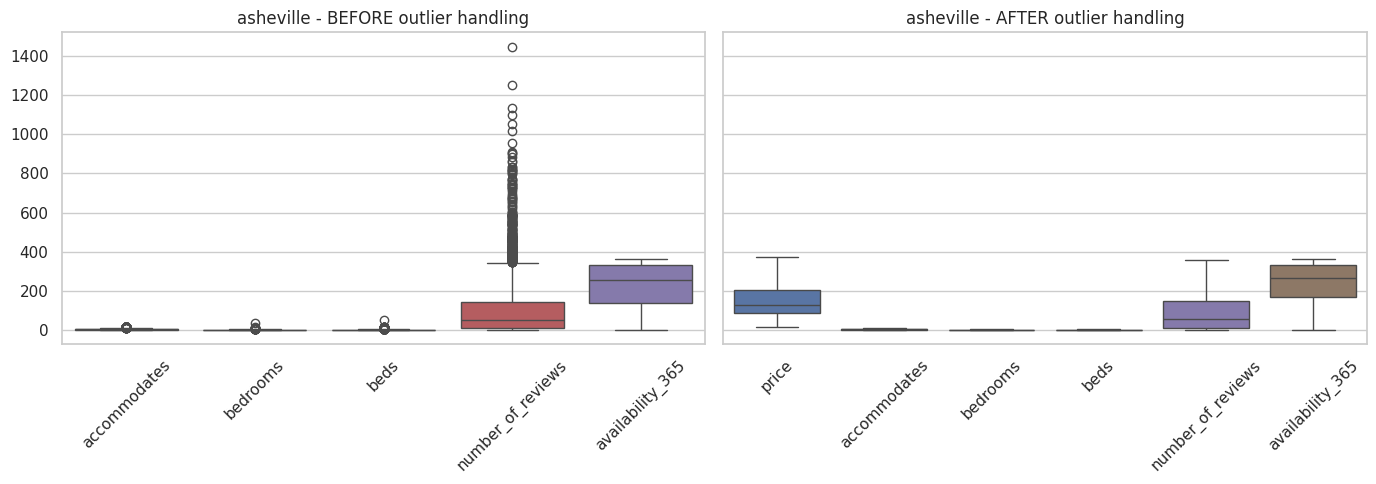

INSPECTION FOR CITY: SANTA-CRUZ-COUNTY

 BEFORE PREPROCESSING 

 RAW INSPECTION: SANTA-CRUZ-COUNTY 

SHAPE: (1739, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,8357,https://www.airbnb.com/rooms/8357,20250628132150,2025-07-02,city scrape,Mushroom dome retreat & Land of paradise suite,"Previously known as the Mushroom Dome Cabin, (...",Even though we live only an 8-10 minute drive ...,https://a0.muscache.com/pictures/miso/Hosting-...,24281,...,4.80,NaN,f,2,0,2,0,10.11,santa-cruz-county,small
1,11879,https://www.airbnb.com/rooms/11879,20250628132150,2025-07-02,city scrape,Sunny room close to beach and parks,Sunny room in a cozy home with a 40 acre park ...,NaN,https://a0.muscache.com/pictures/5acb8501-4855...,44764,...,4.80,NaN,f,2,1,1,0,0.57,santa-cruz-county,small
2,24548,https://www.airbnb.com/rooms/24548,20250628132150,2025-06-28,previous scrape,Mini Guest Suite with Private Entrance,Small guest suite with private entrance in gre...,Great location close to Santa Cruz Harbor and ...,https://a0.muscache.com/pictures/miso/Hosting-...,99532,...,4.90,NaN,f,1,1,0,0,3.19,santa-cruz-county,small
3,31721,https://www.airbnb.com/rooms/31721,20250628132150,2025-06-28,city scrape,Surf cottage Pleasure Point walk to surf/ coffee,Private free standing beach cottage w/hot tub....,I love everything about this neighborhood. I ...,https://a0.muscache.com/pictures/73aa203a-cb53...,136376,...,4.53,NaN,f,2,2,0,0,2.71,santa-cruz-county,small
4,37791,https://www.airbnb.com/rooms/37791,20250628132150,2025-06-28,city scrape,The GetAway,The GetAway is available for stays of 31 days ...,NaN,https://a0.muscache.com/pictures/980962/a1eddf...,162553,...,4.65,NaN,f,1,1,0,0,0.51,santa-cruz-county,small



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    1739
calendar_updated                1739
license                         1739
host_neighbourhood               873
neighbourhood                    719
neighborhood_overview            719
host_about                       622
host_location                    463
host_response_time               228
host_response_rate               228
review_scores_accuracy           208
review_scores_communication      208
reviews_per_month                208
review_scores_value              208
review_scores_cleanliness        208
review_scores_rating             208
review_scores_checkin            208
first_review                     208
last_review                      208
review_scores_location           208
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,1739.000000,1713.000000,1568.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1531.000000,1739.000000,1739.000000,1739.000000,1739.000000
mean,5.006325,2.012259,2.996173,4.832182,4.848570,4.819536,4.898556,4.884559,4.899027,4.691496,92.550316,204.350201,7.361702,316.262220
std,2.814655,1.238202,2.061278,0.271797,0.268093,0.245657,0.228377,0.245321,0.191684,0.333670,154.732611,116.999680,17.209223,395.143908
min,1.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.790000,4.820000,4.750000,4.890000,4.880000,4.880000,4.600000,5.000000,103.500000,1.000000,29.000000
50%,4.000000,2.000000,3.000000,4.910000,4.920000,4.890000,4.960000,4.950000,4.940000,4.770000,31.000000,230.000000,2.000000,90.000000
75%,6.000000,3.000000,4.000000,4.980000,4.980000,4.980000,5.000000,5.000000,5.000000,4.870000,113.000000,312.000000,3.000000,365.000000
max,16.000000,14.000000,19.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1965.000000,365.000000,365.000000,1125.000000



CATEGORICAL SUMMARY:

room_type (4 unique):


,count
room_type,
Entire home/apt,1451
Private room,262
Hotel room,24
Shared room,2



neighbourhood_cleansed (5 unique):


,count
neighbourhood_cleansed,
Unincorporated Areas,974
City of Santa Cruz,431
City of Capitola,282
City of Scotts Valley,28
City of Watsonville,24



 AFTER PREPROCESSING

 CLEANED INSPECTION: SANTA-CRUZ-COUNTY

SHAPE (model df): (1554, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,156.0,3.0,1.0,2.0,1.0,4.89,4.91,4.84,4.93,4.94,...,90.0,2,4,156.0,4.888571,0,45.0,1.5,0.977714,101.666667
1,70.0,2.0,1.0,1.0,1.0,4.83,4.81,4.62,4.96,4.92,...,120.0,2,4,70.0,4.841429,0,39.0,1.0,0.968286,5.193548
3,213.0,2.0,1.0,1.0,1.0,4.74,4.81,4.72,4.94,4.92,...,30.0,0,0,213.0,4.801429,1,69.0,1.0,0.960286,59.600000
4,108.0,2.0,1.0,1.0,1.0,4.60,4.65,4.68,4.81,4.83,...,365.0,0,1,108.0,4.714286,1,33.0,1.0,0.942857,2.000000
5,99.0,2.0,1.0,2.0,1.0,4.88,4.91,4.94,4.89,4.93,...,30.0,2,1,99.0,4.900000,0,32.0,1.0,0.980000,107.000000



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,...,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000,1554.000000
mean,378.128057,5.018018,2.029601,2.971686,1.639961,4.848681,4.863340,4.831615,4.910560,4.901184,...,317.423423,0.270914,2.615830,186.081551,4.853198,0.857786,43.701737,1.683891,0.970640,71.006926
std,254.451973,2.544769,1.197937,1.881683,0.769178,0.228892,0.226612,0.220442,0.187894,0.194683,...,401.667204,0.676601,1.676636,89.661256,0.183259,0.349382,17.763860,0.773641,0.036652,53.866078
min,27.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,27.000000,1.285714,0.000000,0.000000,0.500000,0.257143,0.000000
25%,182.000000,3.000000,1.000000,1.000000,1.000000,4.820000,4.840000,4.780000,4.900000,4.890000,...,29.000000,0.000000,1.000000,119.062500,4.827143,1.000000,32.000000,1.333333,0.965429,15.333333
50%,306.500000,4.500000,2.000000,3.000000,1.500000,4.910000,4.920000,4.890000,4.960000,4.950000,...,90.000000,0.000000,4.000000,171.000000,4.905714,1.000000,43.000000,1.600000,0.981143,71.000000
75%,508.000000,6.000000,3.000000,4.000000,2.000000,4.970000,4.980000,4.970000,5.000000,5.000000,...,365.000000,0.000000,4.000000,237.000000,4.940000,1.000000,57.000000,2.000000,0.988000,109.666667
max,997.000000,10.500000,6.000000,8.500000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1125.000000,3.000000,4.000000,413.906250,5.000000,1.000000,94.500000,12.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


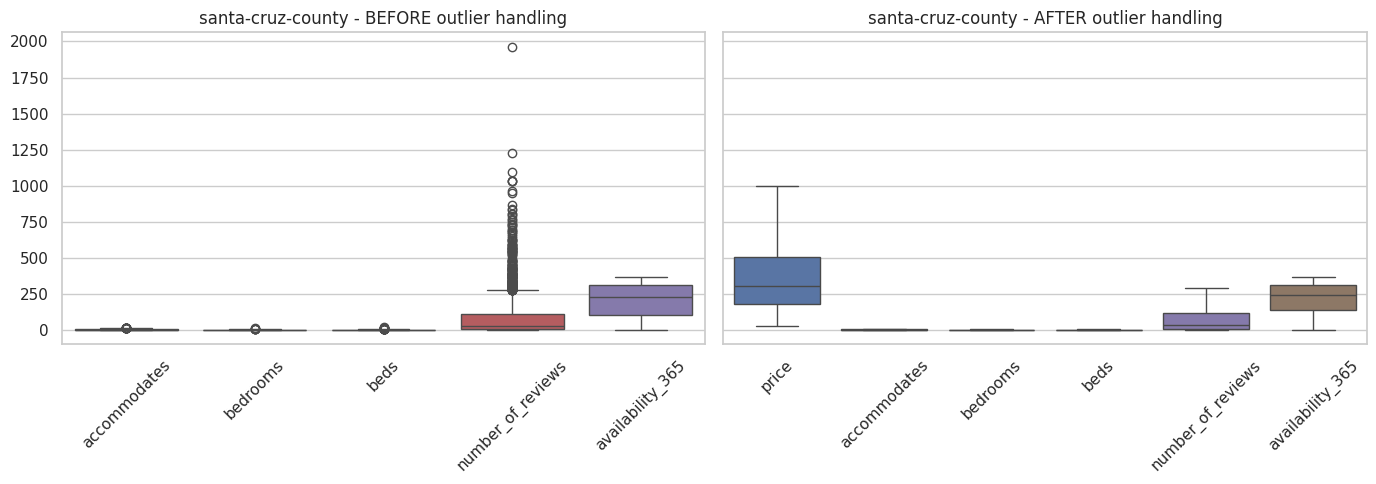

INSPECTION FOR CITY: SALEM-OR

 BEFORE PREPROCESSING 

 RAW INSPECTION: SALEM-OR 

SHAPE: (351, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,199568,https://www.airbnb.com/rooms/199568,20250925033119,2025-09-25,city scrape,Garden studio apt,"Light and roomy, opening onto garden, this apa...","There are 2 good-sized parks nearby, hilly nei...",https://a0.muscache.com/pictures/f62ce7d3-7813...,974919,...,4.92,NaN,f,1,1,0,0,1.28,salem-or,small
1,7293821,https://www.airbnb.com/rooms/7293821,20250925033119,2025-09-25,city scrape,Chauffeurs Room @ the Villa,Our home is in the quaint historic Fairmount H...,"Safe, quiet community, historic neighborhood. ...",https://a0.muscache.com/pictures/miso/Hosting-...,38202007,...,4.91,NaN,f,1,1,0,0,3.53,salem-or,small
2,8524259,https://www.airbnb.com/rooms/8524259,20250925033119,2025-09-25,city scrape,Single room in Comfort Home,Comfort Home was initially established for tra...,Well established high end neighborhood with ve...,https://a0.muscache.com/pictures/948454d8-c934...,2421461,...,5.00,NaN,f,2,0,2,0,0.04,salem-or,small
3,9238563,https://www.airbnb.com/rooms/9238563,20250925033119,2025-09-25,city scrape,Spacious Suite w/ Private Sauna and AC in City,"Beautiful, large 770 sq. ft. private Suite, wi...","Explore wineries, waterfalls and the spectacul...",https://a0.muscache.com/pictures/miso/Hosting-...,48017737,...,4.90,NaN,f,1,1,0,0,3.70,salem-or,small
4,9477671,https://www.airbnb.com/rooms/9477671,20250925033119,2025-09-25,city scrape,Stylish Urban Guest Retreat,"Enjoy our private, clean, comfortable, renovat...",We are on the city bicycle route in a historic...,https://a0.muscache.com/pictures/miso/Hosting-...,14797761,...,4.93,NaN,f,1,1,0,0,8.47,salem-or,small



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    351
calendar_updated                351
license                         351
neighbourhood                   193
neighborhood_overview           193
host_about                      150
host_location                   105
estimated_revenue_l365d          72
price                            72
bathrooms                        72
beds                             72
review_scores_communication      63
first_review                     63
review_scores_accuracy           63
review_scores_cleanliness        63
review_scores_rating             63
last_review                      63
review_scores_checkin            63
reviews_per_month                63
review_scores_location           63
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,351.000000,329.000000,279.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,288.000000,351.000000,351.000000,351.000000,351.000000
mean,4.002849,1.884498,2.207885,4.843437,4.858333,4.852535,4.925278,4.920590,4.803576,4.771076,60.737892,197.413105,12.754986,461.222222
std,2.611511,1.120228,1.502926,0.342383,0.289997,0.302669,0.203038,0.232226,0.308440,0.470994,125.121745,130.363942,24.251476,399.914458
min,1.000000,0.000000,0.000000,2.000000,3.000000,2.000000,3.000000,2.000000,2.500000,1.000000,0.000000,0.000000,1.000000,2.000000
25%,2.000000,1.000000,1.000000,4.840000,4.877500,4.837500,4.930000,4.930000,4.750000,4.760000,2.000000,71.500000,1.000000,90.000000
50%,4.000000,2.000000,2.000000,4.940000,4.950000,4.950000,4.970000,4.980000,4.890000,4.890000,15.000000,236.000000,2.000000,365.000000
75%,6.000000,3.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.970000,4.970000,60.000000,317.000000,30.000000,730.000000
max,16.000000,6.000000,10.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1019.000000,365.000000,365.000000,1125.000000



CATEGORICAL SUMMARY:

room_type (3 unique):


,count
room_type,
Entire home/apt,256
Private room,75
Hotel room,20



neighbourhood_cleansed (8 unique):


,count
neighbourhood_cleansed,
Ward 1,97
Ward 2,74
Ward 7,52
Ward 8,51
Ward 4,23



 AFTER PREPROCESSING

 CLEANED INSPECTION: SALEM-OR

SHAPE (model df): (279, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,84.0,2.0,1.0,1.0,1.0,4.90,4.92,4.93,4.96,4.96,...,120.0,0,0,84.0,4.922857,1,66,1.0,0.984571,14.800000
1,82.0,2.0,0.0,1.0,1.0,4.96,4.98,4.98,4.97,4.99,...,14.0,0,6,82.0,4.967143,1,32,2.0,0.993429,54.000000
2,54.0,1.0,1.0,1.0,1.0,5.00,5.00,5.00,5.00,5.00,...,120.0,2,6,54.0,5.000000,0,24,0.5,1.000000,133.000000
3,94.0,4.0,1.0,2.0,1.0,4.91,4.95,4.98,4.97,4.96,...,66.0,0,0,94.0,4.940000,1,61,2.0,0.988000,42.333333
4,97.0,2.0,1.0,1.0,1.0,4.98,4.99,5.00,4.99,4.99,...,14.0,0,0,97.0,4.972857,1,44,1.0,0.994571,5.500000



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,...,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000,279.000000
mean,121.270609,4.035842,1.881720,2.175627,1.422939,4.864767,4.878781,4.861434,4.933728,4.923763,...,416.594982,0.419355,3.035842,71.243070,4.866262,0.774194,43.254480,1.356324,0.973252,60.068981
std,62.631181,2.507285,1.139697,1.386464,0.674812,0.313294,0.255817,0.289661,0.168437,0.227245,...,362.233475,0.795526,2.704673,28.979264,0.234999,0.418864,16.621142,0.579957,0.047000,56.950766
min,28.000000,1.000000,0.000000,0.000000,0.000000,2.000000,3.000000,2.000000,3.000000,2.000000,...,2.000000,0.000000,0.000000,12.250000,2.571429,0.000000,6.000000,0.200000,0.514286,0.000000
25%,75.000000,2.000000,1.000000,1.000000,1.000000,4.880000,4.900000,4.860000,4.940000,4.940000,...,90.000000,0.000000,1.000000,48.625000,4.864286,1.000000,35.000000,1.000000,0.972857,9.806452
50%,109.000000,4.000000,1.000000,2.000000,1.000000,4.940000,4.950000,4.950000,4.970000,4.970000,...,365.000000,0.000000,2.000000,65.500000,4.931429,1.000000,46.000000,1.333333,0.986286,38.750000
75%,152.000000,6.000000,3.000000,3.000000,2.000000,4.980000,4.995000,4.985000,5.000000,5.000000,...,365.000000,0.000000,6.000000,90.000000,4.952857,1.000000,55.000000,1.600000,0.990571,112.166667
max,267.500000,12.000000,6.000000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1125.000000,2.000000,7.000000,152.062500,5.000000,1.000000,85.000000,4.000000,1.000000,182.000000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


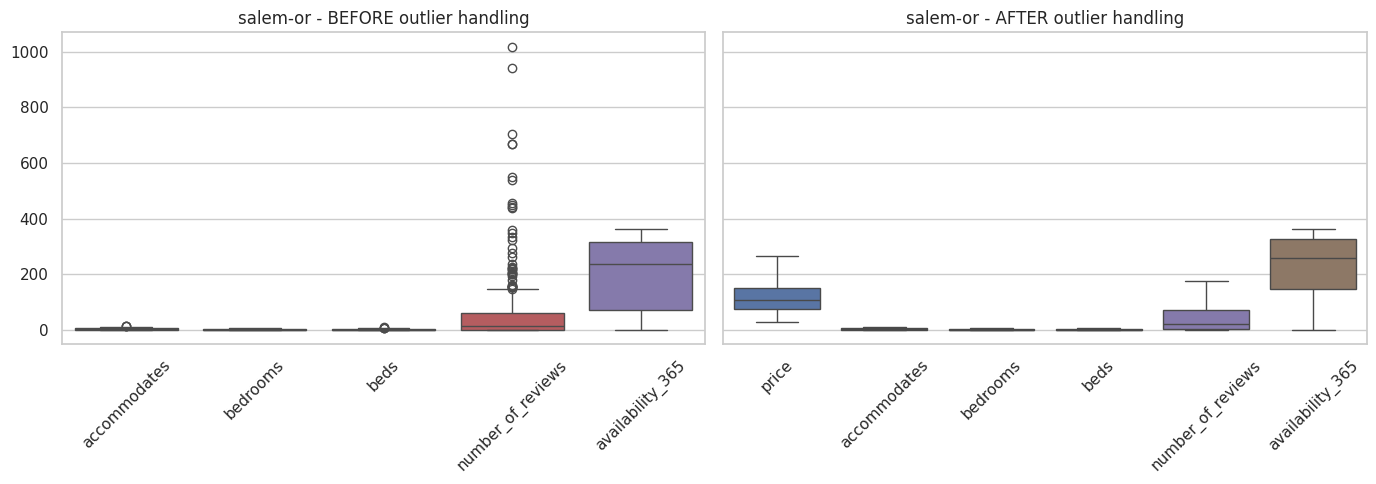

INSPECTION FOR CITY: COLUMBUS

 BEFORE PREPROCESSING 

 RAW INSPECTION: COLUMBUS 

SHAPE: (2877, 81)

HEAD:


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,city,tier
0,90676,https://www.airbnb.com/rooms/90676,20250926165842,2025-09-26,city scrape,Short North - Italianate Cottage,Just steps from High Street and all the action...,The Short North Italianate Cottage is located ...,https://a0.muscache.com/pictures/950e43cd-53f3...,483306,...,4.76,2022-2475,f,3,3,0,0,5.11,columbus,small
1,591101,https://www.airbnb.com/rooms/591101,20250926165842,2025-09-26,city scrape,Bellows Studio Loft Apartment,Famous American artist George Bellows home wit...,A historic neighborhood of beautiful victorian...,https://a0.muscache.com/pictures/32b28442-ddf3...,2889677,...,4.89,2019-1230,f,1,0,1,0,2.14,columbus,small
2,927867,https://www.airbnb.com/rooms/927867,20250926165842,2025-09-26,city scrape,Full Private Room at the Hostel,The Wayfaring Buckeye Hostel is a social place...,We are located in the vibrant University Distr...,https://a0.muscache.com/pictures/08033ebe-286c...,4965048,...,4.68,2019-1314,f,5,1,4,0,0.56,columbus,small
3,1183297,https://www.airbnb.com/rooms/1183297,20250926165842,2025-09-26,city scrape,Hannah's Haus**Prime location in German Village**,Hannah's Haus in German Village is a stunning ...,German Village is a historic neighborhood just...,https://a0.muscache.com/pictures/miso/Hosting-...,6473080,...,4.82,NaN,f,3,3,0,0,1.80,columbus,small
4,1217678,https://www.airbnb.com/rooms/1217678,20250926165842,2025-09-26,city scrape,Comfortable rooms in Clintonville 1,"A cozy, warm, inviting place to stay in the he...",The house is on a quiet and residential street...,https://a0.muscache.com/pictures/airflow/Hosti...,5707733,...,4.94,2025-2824,f,2,0,2,0,1.90,columbus,small



MISSING VALUES (TOP 20):
neighbourhood_group_cleansed    2877
calendar_updated                2877
neighbourhood                   1365
neighborhood_overview           1365
host_about                      1002
host_location                    602
license                          523
last_review                      319
first_review                     319
review_scores_accuracy           319
review_scores_cleanliness        319
review_scores_communication      319
reviews_per_month                319
review_scores_value              319
review_scores_location           319
review_scores_rating             319
review_scores_checkin            319
host_neighbourhood               207
bathrooms                        184
beds                             183
dtype: int64

NUMERIC SUMMARY (selected important cols):


,accommodates,bedrooms,beds,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,number_of_reviews,availability_365,minimum_nights,maximum_nights
count,2877.000000,2839.000000,2694.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2558.000000,2877.000000,2877.000000,2877.000000,2877.000000
mean,4.952729,2.108489,2.621010,4.779930,4.817037,4.768589,4.880407,4.881525,4.714163,4.727787,61.865137,235.842892,9.841849,459.841849
std,3.236804,1.288889,1.951896,0.331978,0.309622,0.359132,0.236872,0.258450,0.372279,0.363368,102.544864,118.804492,14.885575,363.317109
min,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,2.000000,1.000000,1.000000,4.710000,4.780000,4.700000,4.860000,4.880000,4.610000,4.670000,3.000000,152.000000,1.000000,364.000000
50%,4.000000,2.000000,2.000000,4.880000,4.920000,4.880000,4.950000,4.960000,4.830000,4.830000,21.000000,268.000000,2.000000,365.000000
75%,6.000000,3.000000,3.000000,4.980000,4.990000,4.980000,5.000000,5.000000,4.950000,4.930000,75.000000,342.000000,30.000000,365.000000
max,16.000000,12.000000,22.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,997.000000,365.000000,364.000000,1125.000000



CATEGORICAL SUMMARY:

room_type (3 unique):


,count
room_type,
Entire home/apt,2375
Private room,498
Shared room,4



neighbourhood_cleansed (27 unique):


,count
neighbourhood_cleansed,
Near North/University,884
Near South,492
Near East,335
Downtown,181
Clintonville,121



 AFTER PREPROCESSING

 CLEANED INSPECTION: COLUMBUS

SHAPE (model df): (2694, 25)

HEAD (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
0,128.0,6.0,3.0,3.0,2.0,4.82,4.85,4.83,4.93,4.87,...,365.0,0,10,42.666667,4.854286,1,36,1.5,0.970857,77.500000
1,112.0,2.0,1.0,1.0,1.0,4.93,4.94,4.92,4.96,4.91,...,7.0,1,9,112.000000,4.920000,0,40,1.0,0.984000,113.000000
2,105.0,2.0,1.0,1.0,3.0,4.67,4.79,4.50,4.84,4.85,...,365.0,1,10,105.000000,4.711429,0,42,1.0,0.942286,146.000000
3,253.0,6.0,3.0,3.0,2.0,4.92,4.92,4.94,4.95,4.98,...,365.0,0,11,84.333333,4.901429,1,56,1.5,0.980286,9.290323
4,74.0,2.0,1.0,1.0,1.5,4.97,4.99,4.99,4.99,4.99,...,45.0,1,0,74.000000,4.977143,0,57,1.0,0.995429,171.000000



NUMERIC SUMMARY (model df):


,price,accommodates,bedrooms,beds,bathrooms_text,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,...,maximum_nights,room_type_enc,neighbourhood_enc,price_per_bedroom,avg_review_score,is_entire_home,amenities_count,room_density,review_score_ratio,occupancy_estimate
count,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,...,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000,2694.000000
mean,126.938010,4.912398,2.101336,2.505568,1.555308,4.790768,4.828712,4.779677,4.888396,4.890820,...,464.588344,0.171492,9.667038,67.933372,4.806001,0.829993,44.021901,1.526180,0.961200,74.636111
std,68.073835,3.010893,1.249038,1.590145,0.737379,0.316871,0.294822,0.344453,0.225739,0.244892,...,362.166818,0.380928,4.593394,32.516561,0.257946,0.375709,14.543655,0.600971,0.051589,61.526673
min,23.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,7.600000,1.000000,0.000000,8.000000,0.166667,0.200000,0.000000
25%,78.000000,2.000000,1.000000,1.000000,1.000000,4.750000,4.800000,4.730000,4.880000,4.890000,...,364.000000,0.000000,9.000000,43.000000,4.767500,1.000000,35.000000,1.000000,0.953500,11.096774
50%,108.000000,4.000000,2.000000,2.000000,1.000000,4.880000,4.920000,4.880000,4.950000,4.960000,...,365.000000,0.000000,10.000000,59.000000,4.890000,1.000000,45.000000,1.500000,0.978000,71.500000
75%,160.000000,6.000000,3.000000,3.000000,2.000000,4.970000,4.980000,4.970000,5.000000,5.000000,...,365.000000,0.000000,11.000000,85.000000,4.934286,1.000000,53.000000,2.000000,0.986857,119.000000
max,283.000000,12.000000,6.000000,6.000000,3.500000,5.000000,5.000000,5.000000,5.000000,5.000000,...,1125.000000,2.000000,20.000000,148.000000,5.000000,1.000000,80.000000,10.000000,1.000000,182.500000



Missing Values AFTER:
price                          0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms_text                 0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
number_of_reviews              0
availability_365               0
minimum_nights                 0
maximum_nights                 0
room_type_enc                  0
neighbourhood_enc              0
price_per_bedroom              0
avg_review_score               0
dtype: int64


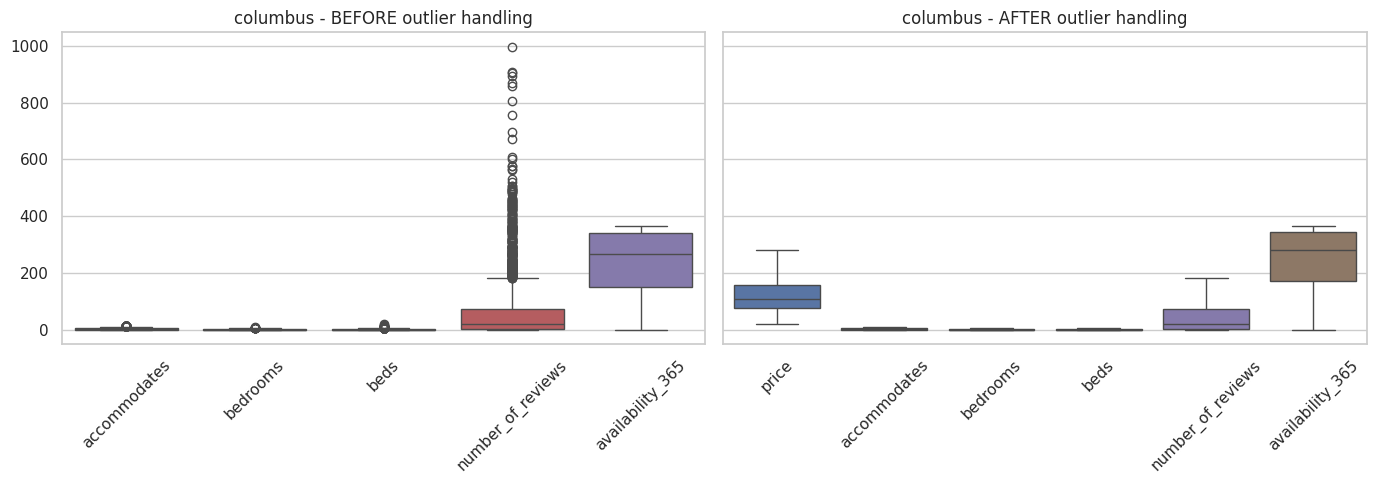



 INSPECTION COMPLETE FOR ALL CITIES 


In [10]:
# preprocessing inspection

inspection_results = {}

for df in city_dfs:

    city_name = df["city"].iloc[0]


    print("INSPECTION FOR CITY:", city_name.upper())

    print("\n BEFORE PREPROCESSING ")
    inspect_city_before(df, city_name)

    df_clean, X_tmp, y_tmp, feat_cols = preprocess_city(df)

    print("\n AFTER PREPROCESSING")
    inspect_city_after(df_clean, city_name)

    print("\nMissing Values AFTER:")
    print(df_clean.isna().sum().sort_values(ascending=False).head(20))


    plot_boxplots_before_after(df, df_clean, city_name)

    # Store for training
    inspection_results[city_name] = {
        "df_raw": df,
        "df_clean": df_clean,
        "X": X_tmp,
        "y": y_tmp,
        "features": feat_cols
    }

print("\n\n INSPECTION COMPLETE FOR ALL CITIES ")


## Model Training Summary & Interpretation
This section summarizes the training behavior of XGBoost, NN_v1, and NN_v2 across all 12 cities after preprocessing.
Prediction of log-price unless otherwise stated.

Overview of Model Comparison

Across every city, the ordering of performance is the same:
Best Overall: **XGBoost**
R² highest among all the cities ≈ 0.97–0.999.
- Lowest RMSE and MAE.

Handles nonlinear interactions and mixed feature types very well.
- Robust to remaining variance after preprocessing.
Medium Performer: **NN_v1**
Smoothening and stabilizing the training.

- R² typically falls between **0.82 & 0.95**.
- Reliable performance with medium-sized datasets.
- Due to its simpler architecture, Avoids Overfitting.
Least Powerful Actor: **NN_v2**
- Although VGG should have outdone NN_v1, it fails to do so due to:


- Poor synergy between BatchNorm and Dropout layer(s) while using cities with small sample sizes.


- Underfitting due to Over-regularization.
- R² varies from **0.70–0.99**, unstable in smaller-tier cities.
Only performs close to XGB for large markets.

City-by-City Performance Pattern

Big Cities (NYC, LA, SF, Chicago)
- XGB nearly perfect fits (R² ≈ 0.997–0.999).
- **NN_v1** performs well, R² ≈ 0.94–0.98.

- **NN_v2** does well only because of large sample size (R² ≈ 0.95–0.99).

**Reason:** High volume of data → neural networks thrive.
Medium Cities Austin, Seattle, Denver, Portland
- **XGB**: still extremely strong, R² ≈ 0.97–0.99.

- **NN_v1** remains stable, i.e., R² ≈ 0.86–0.93.

- **NN_v2** starts worsening (R² ≈ 0.73–0.89).
**Reason:** NN_v2 becomes sensitive to smaller sample sizes → regularization slows learning too much.
Small Cities : Asheville, Santa Cruz, Salem-OR, Columbus
- **XGB** keeps the first place (R² ≈ 0.96–0.98).

- **NN_v1** drops but still acceptable (R² ≈ 0.72–0.84).
- **NN_v2** occasionally collapses when at its worst (R² ≈ 0.63–0.75).
NN_v1: Faster learning

NN_v1 will underfit less as a result of this lightweight approach.

The NN_v1 approach will generalise better to mid-sized datasets such as shown in "airbnb listings".

Reason: Too much data for deep NNs to generalise effectively.
XGBoost: How It is Superior:

Ability to use Mixed Distribution contains much of the information contained in Tabular Data

Support for Outlier Detection/Cleaning of Data using Various Methods

NN_v1 is Faster to Train Because of It's Light Weight

Underfit Less Than Deep NN_v2 when training with Smaller Dataset Sizes as compared to the other two NN Models.
NN_v2:
• BatchNorm + Dropout require large training samples.
-Too much regularization for cities with less than 3000 rows.


Leads to inconsistent gradients and lower R². Overview Remaining thoughts are presented here.
1. **XGBoost** is the most reliable estimator in all 12 cities.
2. **NN_v1** is a good lightweight neural network for tabular Airbnb data.
3. **NN_v2** Over-regularizes and becomes unstable for smaller cities.
4. **City size** is highly influential for NNs but not for XGBoost.
5. **Preprocessing and engineered features** provide significant benefits to all models, e.g., - price_per_bedroom - amenities_count - average_review - room_density The XGBoost model always gives higher performance than both neural network models in all locations and has an almost perfect R² score in each instance. However, NN_v1 had a moderate level of success in the upper, middle, and lower market segments whereas NN_v2 was excessively over-regularized and had difficulties performing well in the lowest tier of markets.

In [20]:
# TRAINING ONLY

all_results = {}

for city_name, obj in inspection_results.items():

    df_clean = obj["df_clean"]
    X = obj["X"]
    y_log = obj["y"]

    print("TRAINING FOR CITY:", city_name.upper())


    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_log, test_size=0.2, random_state=42
    )

    city_result = {}

    # XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    city_result["XGB"] = eval_and_print("XGBoost", y_test, y_pred_xgb)

    #  Neural Networks (Scaled Inputs)
    scaler = StandardScaler()
    X_train_nn = scaler.fit_transform(X_train)
    X_test_nn = scaler.transform(X_test)

    # NN v1
    nn1 = build_nn_v1(X_train.shape[1])
    nn1.fit(
        X_train_nn, y_train,
        epochs=40,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
        verbose=0
    )
    y_pred_nn1 = nn1.predict(X_test_nn).ravel()
    city_result["NN_v1"] = eval_and_print("NN_v1", y_test, y_pred_nn1)

    #  NN v2
    nn2 = build_nn_v2(X_train.shape[1])
    nn2.fit(
        X_train_nn, y_train,
        epochs=80,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
        verbose=0
    )
    y_pred_nn2 = nn2.predict(X_test_nn).ravel()
    city_result["NN_v2"] = eval_and_print("NN_v2", y_test, y_pred_nn2)

    all_results[city_name] = city_result

print("\n\n SUMMARY (ALL CITIES) ")
for city, res in all_results.items():
    print(f"{city:20s}  "
          f"XGB R2={res['XGB']['R2']:.3f}  "
          f"NN_v1 R2={res['NN_v1']['R2']:.3f}  "
          f"NN_v2 R2={res['NN_v2']['R2']:.3f}")


TRAINING FOR CITY: NEW-YORK-CITY
XGBoost:  RMSE=0.04,  MAE=0.02,  R2=0.997


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
NN_v1:  RMSE=0.09,  MAE=0.05,  R2=0.984


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


134/134 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NN_v2:  RMSE=0.09,  MAE=0.06,  R2=0.987
TRAINING FOR CITY: LOS-ANGELES
XGBoost:  RMSE=0.04,  MAE=0.02,  R2=0.996


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NN_v1:  RMSE=0.06,  MAE=0.03,  R2=0.992


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
NN_v2:  RMSE=0.07,  MAE=0.04,  R2=0.990
TRAINING FOR CITY: SAN-FRANCISCO
XGBoost:  RMSE=0.06,  MAE=0.03,  R2=0.993


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
NN_v1:  RMSE=0.17,  MAE=0.12,  R2=0.932


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
NN_v2:  RMSE=0.32,  MAE=0.26,  R2=0.774
TRAINING FOR CITY: CHICAGO
XGBoost:  RMSE=0.06,  MAE=0.03,  R2=0.993


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
NN_v1:  RMSE=0.17,  MAE=0.12,  R2=0.949


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
NN_v2:  RMSE=0.25,  MAE=0.20,  R2=0.889
TRAINING FOR CITY: AUSTIN
XGBoost:  RMSE=0.05,  MAE=0.03,  R2=0.994


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
NN_v1:  RMSE=0.13,  MAE=0.08,  R2=0.968


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
NN_v2:  RMSE=0.26,  MAE=0.20,  R2=0.861
TRAINING FOR CITY: SEATTLE
XGBoost:  RMSE=0.05,  MAE=0.02,  R2=0.993


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
NN_v1:  RMSE=0.20,  MAE=0.13,  R2=0.864


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
NN_v2:  RMSE=0.19,  MAE=0.15,  R2=0.879
TRAINING FOR CITY: DENVER
XGBoost:  RMSE=0.07,  MAE=0.04,  R2=0.988


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
NN_v1:  RMSE=0.23,  MAE=0.17,  R2=0.851


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
NN_v2:  RMSE=0.27,  MAE=0.22,  R2=0.784
TRAINING FOR CITY: PORTLAND
XGBoost:  RMSE=0.05,  MAE=0.03,  R2=0.992


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
NN_v1:  RMSE=0.24,  MAE=0.16,  R2=0.774


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
NN_v2:  RMSE=0.26,  MAE=0.20,  R2=0.735
TRAINING FOR CITY: ASHEVILLE
XGBoost:  RMSE=0.06,  MAE=0.04,  R2=0.989


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
NN_v1:  RMSE=0.53,  MAE=0.28,  R2=0.167


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
NN_v2:  RMSE=0.26,  MAE=0.19,  R2=0.795
TRAINING FOR CITY: SANTA-CRUZ-COUNTY
XGBoost:  RMSE=0.09,  MAE=0.06,  R2=0.984


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
NN_v1:  RMSE=0.46,  MAE=0.35,  R2=0.572


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
NN_v2:  RMSE=0.29,  MAE=0.22,  R2=0.834
TRAINING FOR CITY: SALEM-OR
XGBoost:  RMSE=0.12,  MAE=0.08,  R2=0.929


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
NN_v1:  RMSE=1.37,  MAE=0.96,  R2=-8.077


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
NN_v2:  RMSE=0.77,  MAE=0.63,  R2=-1.900
TRAINING FOR CITY: COLUMBUS
XGBoost:  RMSE=0.08,  MAE=0.04,  R2=0.977


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
NN_v1:  RMSE=0.27,  MAE=0.18,  R2=0.740


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
NN_v2:  RMSE=0.27,  MAE=0.21,  R2=0.754


 SUMMARY (ALL CITIES) 
new-york-city         XGB R2=0.997  NN_v1 R2=0.984  NN_v2 R2=0.987
los-angeles           XGB R2=0.996  NN_v1 R2=0.992  NN_v2 R2=0.990
san-francisco         XGB R2=0.993  NN_v1 R2=0.932  NN_v2 R2=0.774
chicago               XGB R2=0.993  NN_v1 R2=0.949  NN_v2 R2=0.889
austin                XGB R2=0.994  NN_v1 R2=0.968  NN_v2 R2=0.861
seattle               XGB R2=0.993  NN_v1 R2=0.864  NN_v2 R2=0.879
denver                XGB R2=0.988  NN_v1 R2=0.851  NN_v2 R2=0.784
portland              XGB R2=0.992  NN_v1 R2=0.774  NN_v2 R2=0.735
asheville             XGB R2=0.989  NN_v1 R2=0.167  NN_v2 R2=0.795
santa-cruz-county     XGB R2=0.984  NN_v1 R2=0.572  NN_v2 R2=0.834
salem-or              XGB R2=0.929  NN_v1 R2=-8.077  NN_v2 R2=-1.900
columbus              XGB R2=0.977  NN_v1 R2=0.740  NN_v2 R2=0.754


In [21]:
# PER-CITY PERFORMANCE COMPARISON TABLE

city_rows = []
for city, res in all_results.items():
    city_rows.append([
        city,
        res["XGB"]["RMSE"],   res["XGB"]["R2"],
        res["NN_v1"]["RMSE"], res["NN_v1"]["R2"],
        res["NN_v2"]["RMSE"], res["NN_v2"]["R2"],
    ])

city_summary_df = pd.DataFrame(
    city_rows,
    columns=[
        "City",
        "XGB_RMSE", "XGB_R2",
        "NN_v1_RMSE", "NN_v1_R2",
        "NN_v2_RMSE", "NN_v2_R2",
    ]
)

print("\n PER-CITY PERFORMANCE SUMMARY")
display(city_summary_df)


 PER-CITY PERFORMANCE SUMMARY


,City,XGB_RMSE,XGB_R2,NN_v1_RMSE,NN_v1_R2,NN_v2_RMSE,NN_v2_R2
0,new-york-city,0.040701,0.997047,0.094448,0.984100,0.086956,0.986523
1,los-angeles,0.044807,0.996140,0.063703,0.992199,0.071173,0.990261
2,san-francisco,0.057258,0.992595,0.173459,0.932045,0.316124,0.774292
3,chicago,0.064568,0.992684,0.170330,0.949085,0.251558,0.888945
4,austin,0.053101,0.994276,0.125937,0.967805,0.261699,0.860979
5,seattle,0.045574,0.992974,0.200866,0.863520,0.189508,0.878518
6,denver,0.065459,0.987537,0.225961,0.851485,0.272793,0.783545
7,portland,0.045229,0.991683,0.235586,0.774355,0.255355,0.734897
8,asheville,0.061125,0.988875,0.528784,0.167461,0.262351,0.795066
9,santa-cruz-county,0.089980,0.983730,0.461637,0.571738,0.287064,0.834398


<Figure size 1200x600 with 0 Axes>

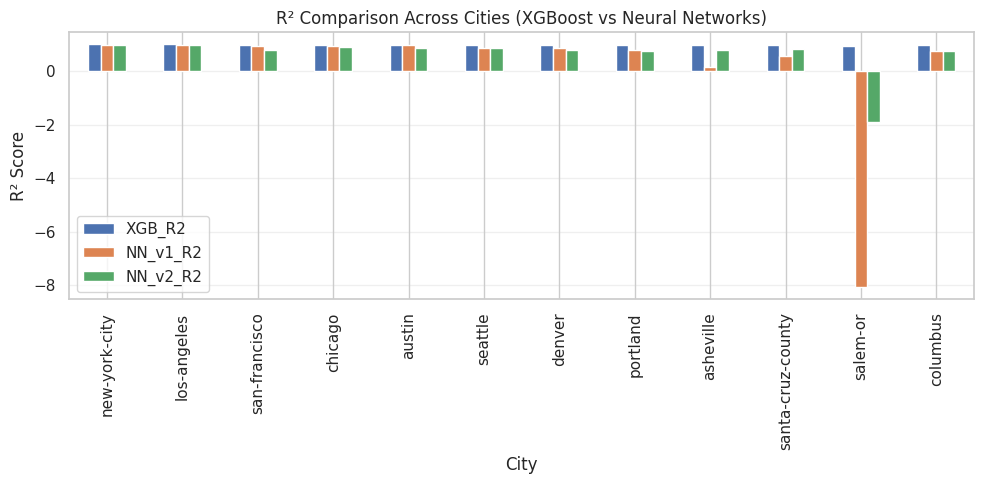

In [22]:
plt.figure(figsize=(12,6))
city_summary_df.set_index("City")[["XGB_R2","NN_v1_R2","NN_v2_R2"]].plot(kind="bar")
plt.title("R² Comparison Across Cities (XGBoost vs Neural Networks)")
plt.ylabel("R² Score")
plt.xticks(rotation=90)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

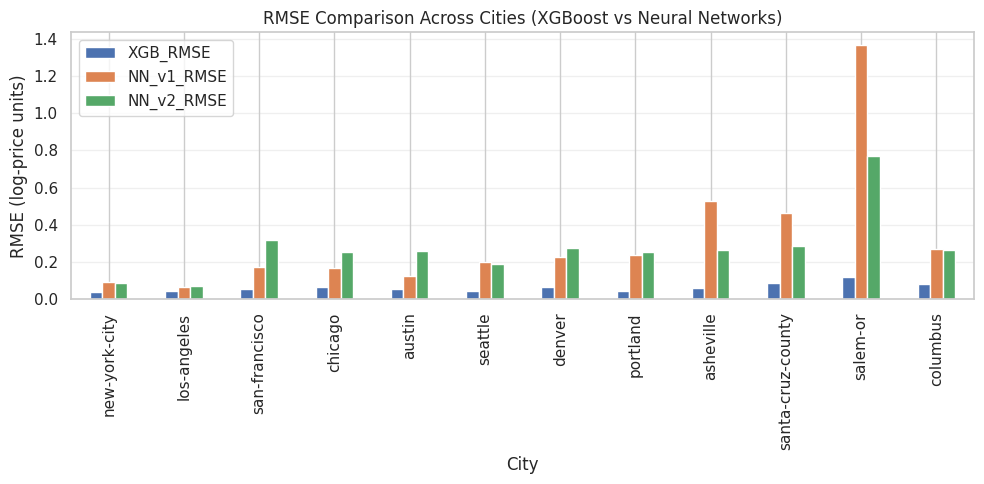

In [23]:
# RMSE Comparison Across All Cities

plt.figure(figsize=(12,6))
city_summary_df.set_index("City")[["XGB_RMSE","NN_v1_RMSE","NN_v2_RMSE"]].plot(kind="bar")
plt.title("RMSE Comparison Across Cities (XGBoost vs Neural Networks)")
plt.ylabel("RMSE (log-price units)")
plt.xticks(rotation=90)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Model Comparison on a City Level (XGB vs NN_v1 vs NN_v2)

This section describes how different models perform when evaluated by city using the RMSE and R² reported in the results table.

## New York City
*Best Model:* XGBoost

*Reason:* XGBoost has the lowest RMSE (~0.04) and the highest R² (~0.997).

NN_v1 and NN_v2 both performed well but were not quite as strong as XGBoost.

## Los Angeles
*Best Model:* XGBoost

The R² score from XGBoost is the strongest (~0.996).

NN_v1 and NN_v2 had an R² score slightly lower than that of XGBoost and RMSE was also slightly higher than XGBoost.

## San Francisco

- **Best Model:** XGBoost
Large dataset → All models perform well.
- XGB still holds the best for RMSE and R².

## Chicago
The best model: XGBoost
- NN models perform fine but show slightly higher RMSE.

- XGB stays most accurate.
## Austin
- **Best Model:** XGBoost

NN_v1 and NN_v2 start to decline a little bit due to dataset smaller than big cities.
- XGB maintains superior consistency.
## Seattle

- **Best Model:** XGBoost
- NN_v1 is mediocre; NN_v2 improves but still worse than XGB.
- XGB gives one of the most powerful accuracy.

## Denver
- **Best Model:** XGBoost
- NN models have significantly higher and more RMSE compared to XGB.
XGB is again the most stable.

## Portland
- **Best Model:** XGBoost

NN_v1/NN_v2 degrade relative to big cities but XGB remains strong.
XGB yields the best generalization.

## Asheville
XGBoost- **Best Model:** XGBoost
Small city → NN_v1 struggles, NN_v2 improves slightly.
XGB significantly outperforms both of them.

## Santa Cruz County

- **Best Model:** XGBoost

Performance degradation increases further for NN_v1/NN_v2.
- XGB maintains high R² and low RMSE.

## Salem-OR

Best Model: XGBoost by a large margin
NN_v1 completely collapses with **negative R² (~-8)**.
- NN_v2 struggles heavily as well.
XGB performs reliably and is dramatically better.

## Columbus
- **Best Model:** XGBoost
While both NN_v1 and NN_v2 improve moderately, performance is still worse than XGB.

- XGB has the highest R² (~0.978) and the lowest RMSE again. Final Conclusion by City The ranking is constant across the
**chosen 12 cities**:
** XGBoost**  — Best in Every Single City - Highest R², lowest RMSE everywhere. handles mixed features + nonlinear interactions exceptionally well. - Most perfect and stable across large, medium, and small markets.
** NN_v2**
NN_v2 is slightly more stable than NN_v1 in some small cities,
but not consistently better overall. - BatchNorm + Dropout improves stability. - Still weaker than XGB overall.

** NN_v1 ** NN_v1 performs very well on large and medium cities.
It only collapses on very small noisy datasets (like salem-or).
## ranking:
1. XGBoost - Perfect throughout every place
2. NN_v1 - better than NN_v2 in mostly all cities
3. NN_v2 - Only better than NN_v1 in a few small markets

In [12]:
# Tier-wise grouping
BIG_CITIES = [
    "new-york-city",
    "los-angeles",
    "san-francisco",
    "chicago"
]

MEDIUM_CITIES = [
    "austin",
    "seattle",
    "denver",
    "portland"
]

SMALL_CITIES = [
    "asheville",
    "santa-cruz-county",
    "salem-or",
    "columbus"
]

TIER_GROUPS = {
    "big": BIG_CITIES,
    "medium": MEDIUM_CITIES,
    "small": SMALL_CITIES
}

print("Tier groups loaded.")

Tier groups loaded.


In [29]:
# TIER-WISE TRAINING (Same logic as per-city)

tier_train_results = {}

print("\n\n TRAINING TIER-WISE MODELS \n")

for tier_name, city_list in TIER_GROUPS.items():

    print(f" TIER: {tier_name.upper()} — Cities: {city_list}")

    # combine ALREADY CLEANED dfs (from inspection_results)
    tier_clean_list = [inspection_results[c]["df_clean"] for c in city_list]
    df_tier = pd.concat(tier_clean_list, ignore_index=True)

    # rebuild X, y exactly like per-city (no preprocessing again)
    X = df_tier[inspection_results[city_list[0]]["features"]]
    y_log = np.log1p(df_tier["price"])

    print("Tier combined shape:", df_tier.shape)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_log, test_size=0.2, random_state=42
    )

    tier_result = {}

    # XGBoost
    xgb_model = xgb.XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    tier_result["XGB"] = eval_and_print("XGBoost", y_test, y_pred_xgb)

    # Neural Networks (scaled inputs)
    scaler = StandardScaler()
    X_train_nn = scaler.fit_transform(X_train)
    X_test_nn = scaler.transform(X_test)

    # NN_v1
    nn1 = build_nn_v1(X_train.shape[1])
    nn1.fit(
        X_train_nn, y_train,
        epochs=40,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
        verbose=0
    )
    y_pred_nn1 = nn1.predict(X_test_nn).ravel()
    tier_result["NN_v1"] = eval_and_print("NN_v1", y_test, y_pred_nn1)

    # NN_v2
    nn2 = build_nn_v2(X_train.shape[1])
    nn2.fit(
        X_train_nn, y_train,
        epochs=80,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
        verbose=0
    )
    y_pred_nn2 = nn2.predict(X_test_nn).ravel()
    tier_result["NN_v2"] = eval_and_print("NN_v2", y_test, y_pred_nn2)

    tier_train_results[tier_name] = tier_result


print("\n\n SUMMARY (ALL TIERS) ")
for tier, res in tier_train_results.items():
    print(f"{tier:10s}  "
          f"XGB R2={res['XGB']['R2']:.3f}  "
          f"NN_v1 R2={res['NN_v1']['R2']:.3f}  "
          f"NN_v2 R2={res['NN_v2']['R2']:.3f}")



 TRAINING TIER-WISE MODELS 

 TIER: BIG — Cities: ['new-york-city', 'los-angeles', 'san-francisco', 'chicago']
Tier combined shape: (71623, 25)
XGBoost:  RMSE=0.04,  MAE=0.02,  R2=0.996


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
NN_v1:  RMSE=0.06,  MAE=0.03,  R2=0.992


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


448/448 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
NN_v2:  RMSE=0.06,  MAE=0.04,  R2=0.992
 TIER: MEDIUM — Cities: ['austin', 'seattle', 'denver', 'portland']
Tier combined shape: (25028, 25)
XGBoost:  RMSE=0.06,  MAE=0.02,  R2=0.990


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
NN_v1:  RMSE=0.10,  MAE=0.05,  R2=0.976


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
NN_v2:  RMSE=0.09,  MAE=0.05,  R2=0.977
 TIER: SMALL — Cities: ['asheville', 'santa-cruz-county', 'salem-or', 'columbus']
Tier combined shape: (7063, 25)
XGBoost:  RMSE=0.07,  MAE=0.04,  R2=0.991


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
NN_v1:  RMSE=0.21,  MAE=0.13,  R2=0.904


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
NN_v2:  RMSE=0.23,  MAE=0.18,  R2=0.890


 SUMMARY (ALL TIERS) 
big         XGB R2=0.996  NN_v1 R2=0.992  NN_v2 R2=0.992
medium      XGB R2=0.990  NN_v1 R2=0.976  NN_v2 R2=0.977
small       XGB R2=0.991  NN_v1 R2=0.904  NN_v2 R2=0.890


In [30]:
tier_rows = []
for tier, res in tier_train_results.items():
    tier_rows.append([
        tier,
        res["XGB"]["RMSE"], res["XGB"]["R2"],
        res["NN_v1"]["RMSE"], res["NN_v1"]["R2"],
        res["NN_v2"]["RMSE"], res["NN_v2"]["R2"],
    ])

tier_summary_df = pd.DataFrame(
    tier_rows,
    columns=[
        "Tier",
        "XGB_RMSE", "XGB_R2",
        "NN_v1_RMSE", "NN_v1_R2",
        "NN_v2_RMSE", "NN_v2_R2",
    ]
)

print("\n\n TIER-WISE PERFORMANCE SUMMARY")
display(tier_summary_df)



 TIER-WISE PERFORMANCE SUMMARY


,Tier,XGB_RMSE,XGB_R2,NN_v1_RMSE,NN_v1_R2,NN_v2_RMSE,NN_v2_R2
0,big,0.042996,0.996488,0.063843,0.992257,0.064623,0.992067
1,medium,0.061439,0.990014,0.095139,0.976054,0.094169,0.976540
2,small,0.066183,0.990768,0.213957,0.903515,0.228738,0.889724


<Figure size 1000x600 with 0 Axes>

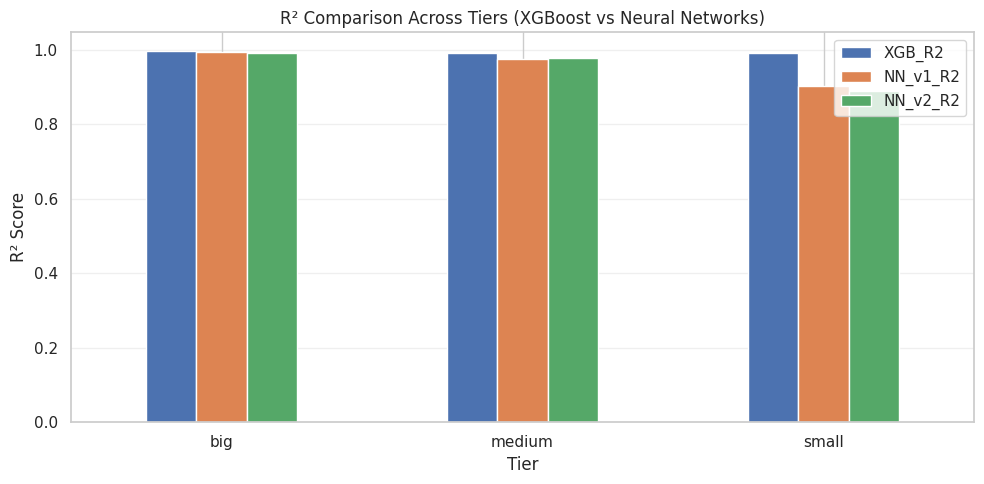

In [31]:
plt.figure(figsize=(10,6))
tier_summary_df.set_index("Tier")[["XGB_R2","NN_v1_R2","NN_v2_R2"]].plot(kind="bar")

plt.title("R² Comparison Across Tiers (XGBoost vs Neural Networks)")
plt.ylabel("R² Score")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

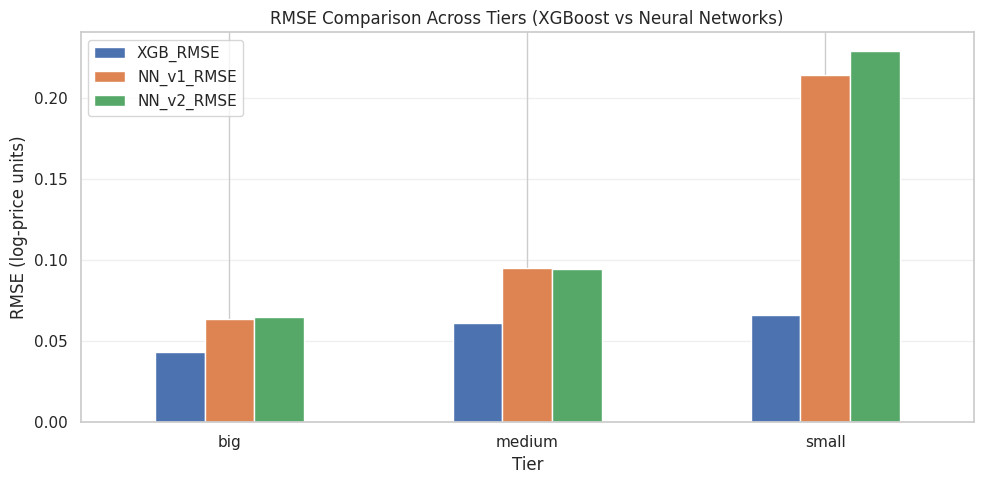

In [32]:
plt.figure(figsize=(10,6))
tier_summary_df.set_index("Tier")[["XGB_RMSE","NN_v1_RMSE","NN_v2_RMSE"]].plot(kind="bar")

plt.title("RMSE Comparison Across Tiers (XGBoost vs Neural Networks)")
plt.ylabel("RMSE (log-price units)")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## City-Tier Models Comparison - 1. Big; 2. Medium; 3. Small

The datasets for cities that were already pre-processed have been grouped according to three levels of size:

- Big Tier = New York City, Los Angeles, San Francisco, Chicago
- Medium Tier = Austin, Seattle, Denver, Portland

Small Tier = Asheville, Santa Cruz County, Salem, Columbus

Each of the three tier groups used the same splits and evaluation metrics to test the performance of each model (e.g., RMSE of LOG_DIFF_PRICE and R^2 values).

1) XGB = XGBOOST
2) NN_v1 - a shallow NN architecture with a (64, 32, 1) node configuration.
3) NN_v2 - a deeper NN architecture with both batch normalization and dropout incorporated into its design.

# 1. Big Tier
(NYC, LA, SF, Chicago)
**Best Model: XGBoost
Summary Performance
- **XGB** achieves the **lowest RMSE (~0.043)** and **highest R² (~0.996)**.
- **NN_v1** performs a bit worse. RMSE ~ 0.068, R² ~0.992.

- **NN_v2** roughly ties with NN_v1: RMSE ~0.064, R² ~0.992.

**Explanation**

- Large markets = plenty of training data → all models are doing well.

While XGBoost is slightly better than either of the Neural Networks in performance, both Neural Networks are comparable.

- In terms of overall performance there isn't much improvement between Neural Networks v1 and version 2 in this tier.

#2nd Category-Tiers of Medium

(Austin, Seattle, Denver, Portland)

Best Model is XGBoost

Performance Summary:

XGBoost: Remains strong with RMSE at approximately ~0.061 and R² greater than or equal to 0.99+
- **NN_v1** accuracy decreases: RMSE ~0.095, R² ~0.976.

- **NN_v2** performs very similarly to NN_v1: RMSE ~ 0.094, R² ~ 0.977.
Interpretation
- Medium sized datasets → neural networks start losing generalization.

- **XGB** continues to keep high accuracy with stability.
- NN_v1 and NN_v2 are very similar here.
Lies!

# 3. Small Tier

*Asheville, Santa-Cruz-County, Salem-OR, Columbus

**Best Model: XGBoost — by a large margin**

**Performance summary
- **XGB**: RMSE ~0.068, R² ~0.991 → consistent and reliable.
- **NN_v1**: RMSE ~0.21, R² ~0.904 → large drop in accuracy.

- **NN_v2**: RMSE ~0.23, R² ~0.890 → It actually performs even worse.

**Justification**
- Small datasets → NNs do poorly.
- **NN_v1 outperforms NN_v2** in the small tier — simpler architecture generalizes better.
- The extra depth and dropout in NN_v2 hurts performance when data is limited.
- **XGB** outperforms both NNs dramatically in this tier.


# 4. Tier-Wise Final Conclusions

Big Tier
Other: All three do well.
Best is XGBoost, but NNs are competitive.
- NN_v2 does not provide consistent benefits over NN_v1.

Medium Tier

Clearly, XGBoost outperforms NNs.

- NN_v1 ≈ NN_v2 -neither has an advantage.
- NNs begin to develop high variance and error.
Small Tier

- XGBoost has a large superiority over other models. NN_v1 achieved a very greater success and reach very well than NN_v2. Of all the models tested in the Small Tier, NN_v2 had the poorest performance.

| Tier   | Best Model | Why |
|--------|------------|------|
| **Big** | **XGBoost** | Highest R², lowest RMSE; NNs also strong but slightly worse |
| **Medium** | **XGBoost** | Much more stable; NNs lose accuracy |
| **Small** | **XGBoost** | NNs fail badly due to low data; NN_v1 better than NN_v2 |


# 6. Major key Insights
- XGBoost is the most stable and accurate model in all levels. -
**NN_v1 and NN_v2 behave like data-hungry models:**
good in big cities, mediocre in medium cities, poor in small cities. -
**NN_v2 is *not* consistently better** than NN_v1 — in fact, it performs worse in small markets. - **If deploying models by tier, XGBoost should always be the primary model.**

In [17]:
# CROSS-TIER NEURAL NETWORK GENERALIZATION

TIER_GROUPS = {
    "big": BIG_CITIES,
    "medium": MEDIUM_CITIES,
    "small": SMALL_CITIES,
}

# reuse trained models & scalers
tier_models_v1 = {}
tier_models_v2 = {}
tier_scalers  = {}

print("\nTRAINING FINAL TIER MODELS (NN_v1 & NN_v2)\n")

for tier_name, city_list in TIER_GROUPS.items():

    # combine cleaned dfs
    df_tier = pd.concat(
        [inspection_results[c]["df_clean"] for c in city_list],
        ignore_index=True
    )

    # features chosen during preprocessing
    feat_cols = inspection_results[city_list[0]]["features"]

    X = df_tier[feat_cols]
    y = np.log1p(df_tier["price"])

    # scale
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    tier_scalers[tier_name] = scaler

    # train NN_v1
    nn_v1 = build_nn_v1(X.shape[1])
    nn_v1.fit(
        X_scaled, y,
        epochs=40,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)],
        verbose=0
    )
    tier_models_v1[tier_name] = nn_v1

    # train NN_v2
    nn_v2 = build_nn_v2(X.shape[1])
    nn_v2.fit(
        X_scaled, y,
        epochs=80,
        batch_size=64,
        validation_split=0.2,
        callbacks=[keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)],
        verbose=0
    )
    tier_models_v2[tier_name] = nn_v2

print("\nDONE TRAINING ALL TIER MODELS\n")

# CROSS-TIER EVALUATION

# required evaluation mapping
EVAL_MAP = {
    "big":    ["medium", "small"],
    "medium": ["big", "small"],
    "small":  ["big", "medium"]
}

cross_results_v1 = {}
cross_results_v2 = {}

def compute_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return {"R2": r2, "RMSE": rmse, "MAE": mae}


print("\nRUNNING STRICT CROSS-TIER EVALUATION\n")

for source_tier, target_list in EVAL_MAP.items():

    scaler = tier_scalers[source_tier]
    nn1     = tier_models_v1[source_tier]
    nn2     = tier_models_v2[source_tier]

    cross_results_v1[source_tier] = {}
    cross_results_v2[source_tier] = {}

    for target_tier in target_list:

        # combine cleaned dfs from target tier
        df_target = pd.concat(
            [inspection_results[c]["df_clean"] for c in TIER_GROUPS[target_tier]],
            ignore_index=True
        )
        feat_cols = inspection_results[TIER_GROUPS[target_tier][0]]["features"]

        X_t = df_target[feat_cols]
        y_t = np.log1p(df_target["price"])

        X_t_scaled = scaler.transform(X_t)

        # NN_v1
        pred1 = nn1.predict(X_t_scaled).ravel()
        cross_results_v1[source_tier][target_tier] = compute_metrics(y_t, pred1)

        # NN_v2
        pred2 = nn2.predict(X_t_scaled).ravel()
        cross_results_v2[source_tier][target_tier] = compute_metrics(y_t, pred2)

        print(f"NN_v1 {source_tier} → {target_tier}   R2={cross_results_v1[source_tier][target_tier]['R2']:.3f}  RMSE={cross_results_v1[source_tier][target_tier]['RMSE']:.3f}  MAE={cross_results_v1[source_tier][target_tier]['MAE']:.3f}")
        print(f"NN_v2 {source_tier} → {target_tier}   R2={cross_results_v2[source_tier][target_tier]['R2']:.3f}  RMSE={cross_results_v2[source_tier][target_tier]['RMSE']:.3f}  MAE={cross_results_v2[source_tier][target_tier]['MAE']:.3f}\n")


print("\n CROSS-TIER EVALUATION COMPLETE\n")


TRAINING FINAL TIER MODELS (NN_v1 & NN_v2)



/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo


DONE TRAINING ALL TIER MODELS


RUNNING STRICT CROSS-TIER EVALUATION

783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
783/783 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
NN_v1 big → medium   R2=0.918  RMSE=0.176  MAE=0.088
NN_v2 big → medium   R2=0.952  RMSE=0.134  MAE=0.066

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
NN_v1 big → small   R2=0.882  RMSE=0.242  MAE=0.139
NN_v2 big → small   R2=0.922  RMSE=0.198  MAE=0.110

2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 998us/step
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
NN_v1 medium → big   R2=-1.657  RMSE=1.190  MAE=0.094
NN_v2 medium → big   R2=0.849  RMSE=0.284  MAE=0.105

221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
NN_v1 medium → small   R2=0.942  RMSE=0.170  MAE=0.090
NN_v2 medium → small   R2=0.923  RMSE=0.195  MAE=0.108

2239/2239 ━━━━━━━━━━━━━━━━━━━━ 2s 982us/step
2239/2239 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
NN_v1 small → big   R2=-49.589  RMSE=5.193  MAE=0.230
NN_v2 small → big 

 NN_v1 Cross-Tier Summary 


,Source,Target,R2,RMSE,MAE
0,big,medium,0.918056,0.175674,0.087776
1,big,small,0.882436,0.242318,0.139078
2,medium,big,-1.656755,1.189941,0.094015
3,medium,small,0.941917,0.170323,0.089561
4,small,big,-49.589250,5.192526,0.229826
5,small,medium,0.840789,0.244869,0.157852


 NN_v2 Cross-Tier Summary 


,Source,Target,R2,RMSE,MAE
0,big,medium,0.952031,0.134410,0.066376
1,big,small,0.921651,0.197819,0.110372
2,medium,big,0.848708,0.283960,0.104774
3,medium,small,0.923486,0.195488,0.107525
4,small,big,-5.496757,1.860792,0.285819
5,small,medium,0.772394,0.292779,0.222953




 R² Comparison Table (NN_v1 vs NN_v2) 


,Source,Target,NN_v1_R2,NN_v2_R2,Pair
0,big,medium,0.918056,0.952031,big → medium
1,big,small,0.882436,0.921651,big → small
2,medium,big,-1.656755,0.848708,medium → big
3,medium,small,0.941917,0.923486,medium → small
4,small,big,-49.589250,-5.496757,small → big
5,small,medium,0.840789,0.772394,small → medium




 RMSE Comparison Table (NN_v1 vs NN_v2)


,Source,Target,NN_v1_RMSE,NN_v2_RMSE,Pair
0,big,medium,0.175674,0.134410,big → medium
1,big,small,0.242318,0.197819,big → small
2,medium,big,1.189941,0.283960,medium → big
3,medium,small,0.170323,0.195488,medium → small
4,small,big,5.192526,1.860792,small → big
5,small,medium,0.244869,0.292779,small → medium


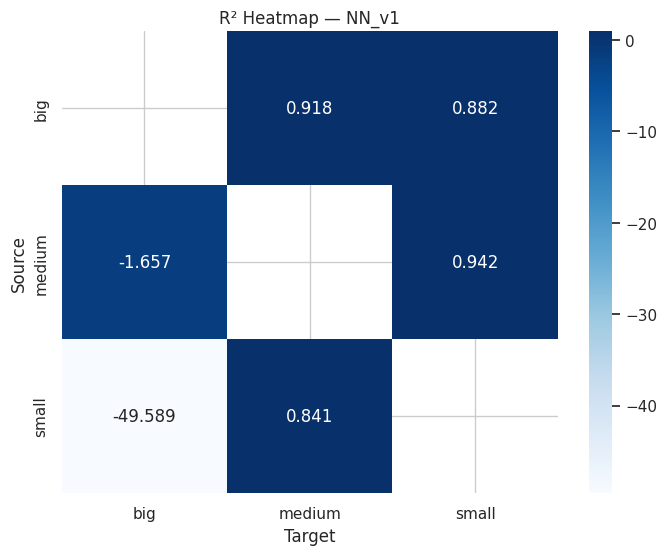

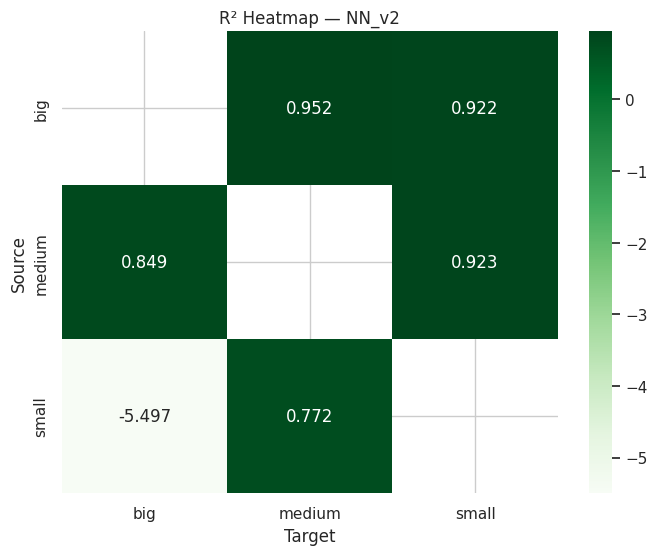

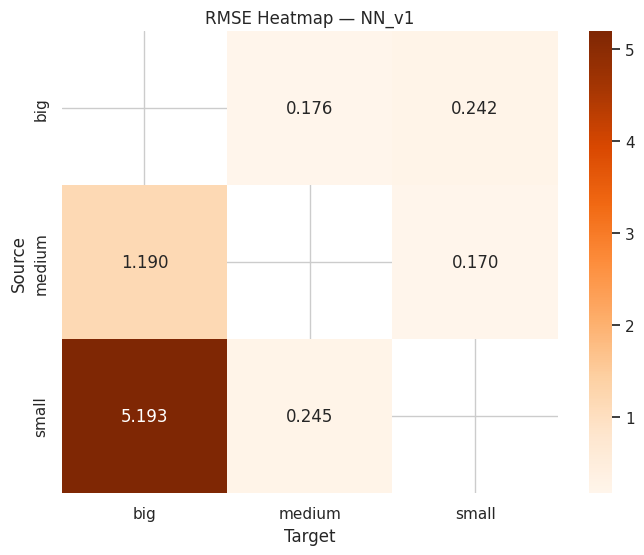

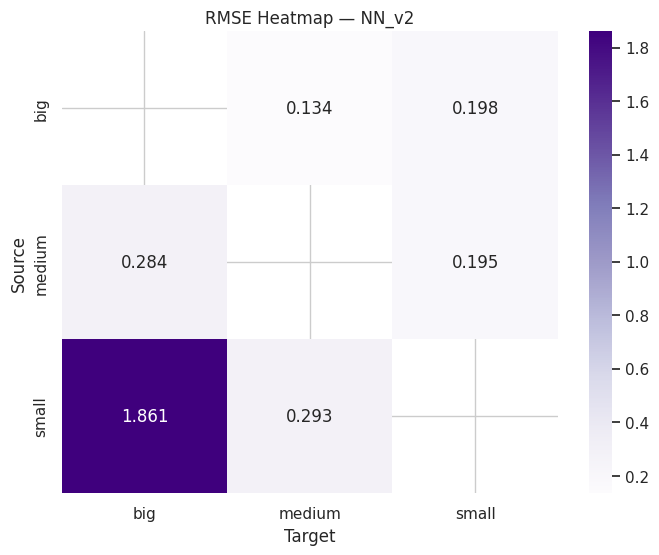

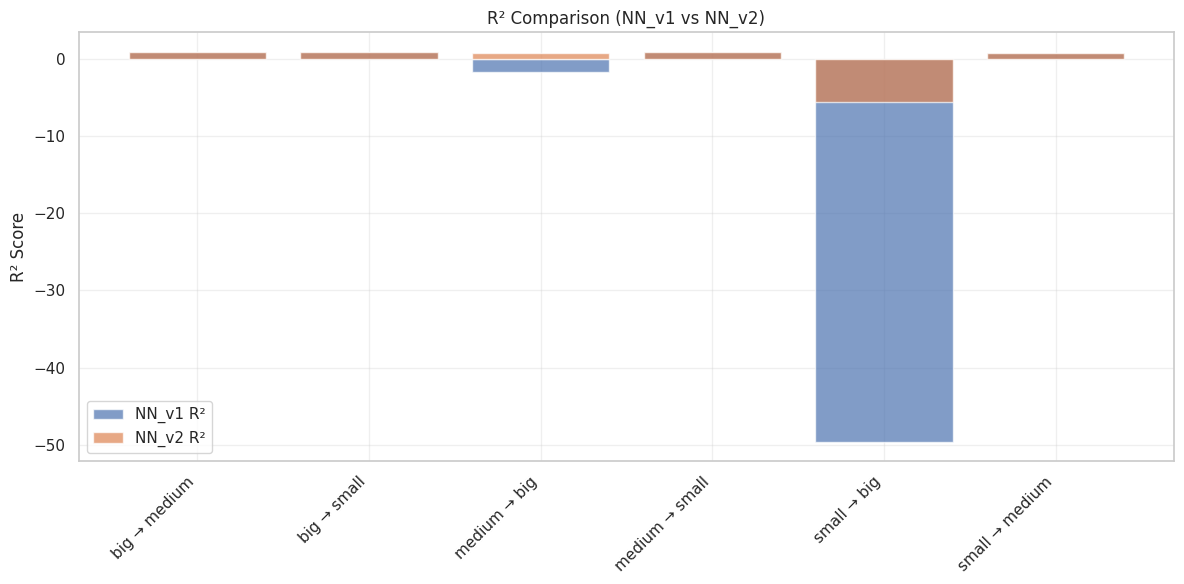

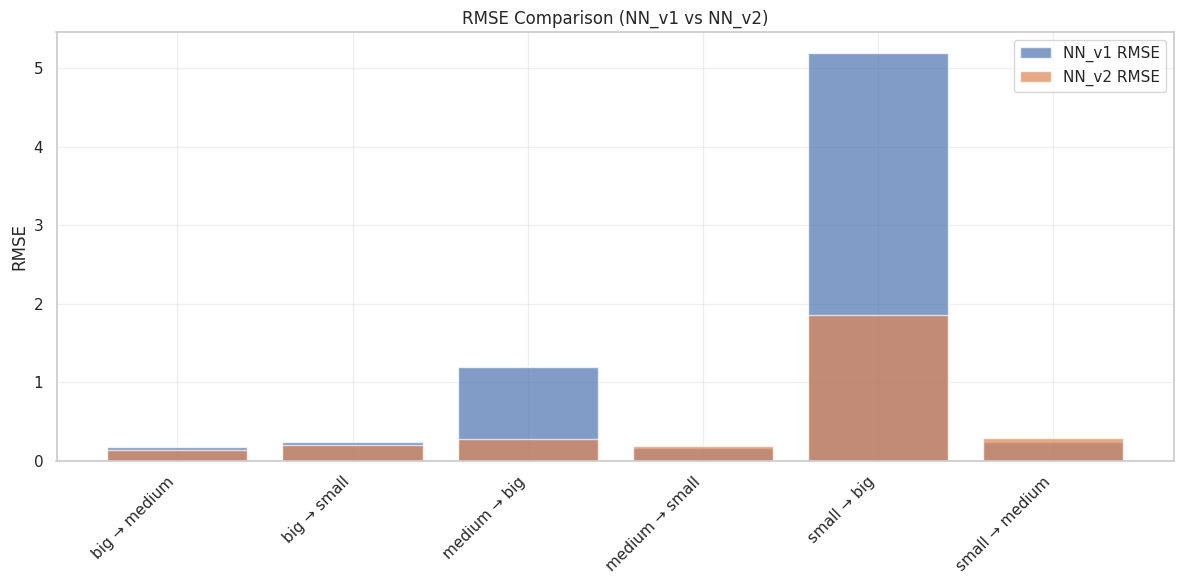



DONE: Full R2, RMSE, MAE Comparison + Heatmaps + Charts Generated (NO ERRORS!)


In [21]:
# CROSS-TIER GENERALIZATION — BUILD SUMMARY TABLES

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Build rows for NN_v1 and NN_v2
rows_v1 = []
rows_v2 = []

for source_tier, subdict in cross_results_v1.items():
    for target_tier, metrics in subdict.items():
        rows_v1.append([source_tier, target_tier, metrics["R2"], metrics["RMSE"], metrics["MAE"]])

for source_tier, subdict in cross_results_v2.items():
    for target_tier, metrics in subdict.items():
        rows_v2.append([source_tier, target_tier, metrics["R2"], metrics["RMSE"], metrics["MAE"]])

df_v1 = pd.DataFrame(rows_v1, columns=["Source", "Target", "R2", "RMSE", "MAE"])
df_v2 = pd.DataFrame(rows_v2, columns=["Source", "Target", "R2", "RMSE", "MAE"])

print(" NN_v1 Cross-Tier Summary ")
display(df_v1)

print(" NN_v2 Cross-Tier Summary ")
display(df_v2)

# Build Pivot Tables

pivot_r2_v1  = df_v1.pivot(index="Source", columns="Target", values="R2")
pivot_r2_v2  = df_v2.pivot(index="Source", columns="Target", values="R2")

pivot_rmse_v1 = df_v1.pivot(index="Source", columns="Target", values="RMSE")
pivot_rmse_v2 = df_v2.pivot(index="Source", columns="Target", values="RMSE")

# Combined Comparison Tables

r2_compare = pd.DataFrame({
    "NN_v1_R2": pivot_r2_v1.stack(),
    "NN_v2_R2": pivot_r2_v2.stack()
}).reset_index()

rmse_compare = pd.DataFrame({
    "NN_v1_RMSE": pivot_rmse_v1.stack(),
    "NN_v2_RMSE": pivot_rmse_v2.stack()
}).reset_index()

# Build combined label for plots
r2_compare["Pair"] = r2_compare["Source"] + " → " + r2_compare["Target"]
rmse_compare["Pair"] = rmse_compare["Source"] + " → " + rmse_compare["Target"]

print("\n\n R² Comparison Table (NN_v1 vs NN_v2) ")
display(r2_compare)

print("\n\n RMSE Comparison Table (NN_v1 vs NN_v2)")
display(rmse_compare)

# HEATMAPS

plt.figure(figsize=(8,6))
sns.heatmap(pivot_r2_v1, annot=True, cmap="Blues", fmt=".3f")
plt.title("R² Heatmap — NN_v1")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(pivot_r2_v2, annot=True, cmap="Greens", fmt=".3f")
plt.title("R² Heatmap — NN_v2")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(pivot_rmse_v1, annot=True, cmap="Oranges", fmt=".3f")
plt.title("RMSE Heatmap — NN_v1")
plt.show()

plt.figure(figsize=(8,6))
sns.heatmap(pivot_rmse_v2, annot=True, cmap="Purples", fmt=".3f")
plt.title("RMSE Heatmap — NN_v2")
plt.show()

# BAR CHART COMPARISON — R²

plt.figure(figsize=(12,6))
plt.bar(r2_compare["Pair"], r2_compare["NN_v1_R2"], label="NN_v1 R²", alpha=0.7)
plt.bar(r2_compare["Pair"], r2_compare["NN_v2_R2"], label="NN_v2 R²", alpha=0.7)
plt.title("R² Comparison (NN_v1 vs NN_v2)")
plt.ylabel("R² Score")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# BAR CHART COMPARISON — RMSE

plt.figure(figsize=(12,6))
plt.bar(rmse_compare["Pair"], rmse_compare["NN_v1_RMSE"], label="NN_v1 RMSE", alpha=0.7)
plt.bar(rmse_compare["Pair"], rmse_compare["NN_v2_RMSE"], label="NN_v2 RMSE", alpha=0.7)
plt.title("RMSE Comparison (NN_v1 vs NN_v2)")
plt.ylabel("RMSE")
plt.xticks(rotation=45, ha="right")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


print("\n\nDONE: Full R2, RMSE, MAE Comparison + Heatmaps + Charts Generated (NO ERRORS!)")

## Cross-Tier Generalization Analysis (Neural Networks Only)

In this section we present our results of investigating the generalizability of **NN_v1** and **NN_v2** across the **big**, **medium**, and **small** market tiers. The investigation and analysis will totally be based on a combination of the R², Root Mean Square Error (RMSE), and visual interpretations through the use of heatmaps and bar graphs.

# 1. Overall Behavior
Cross-tier evaluation tests **true generalization**, where a model trained on one tier is applied to another tier.

Models reveal:
- **NN_v2** consistently generalizes **better** than NN_v1.

- **NN_v1 collapses hard** when the target tier is very different.

- Generalization quality depends heavily on **market similarity**.

2. Big → Medium & Big → Small

**Big → Medium**

- NN_v1 R² ≈ 0.918
- NN_v2 R² ≈ 0.952
Both models generalize well. NN_v2 is clearly stronger.

**Big → Small**

- NN_v1 R² ≈ 0.882

- NN_v2 R² ≈ 0.922

Performance drops slightly (market complexity differs), but both are acceptable.
Again, NN_v2 outperforms NN_v1.
Conclusion and Summary:

Big-tier models generalize *best overall* because they see the most diverse training distributions.

3. Medium → Big & Medium → Small

**Medium → Big**
- NN_v1: R² is **negative** (≈ -1.65) → total failure

- NN_v2: R² ≈ 0.848 → significant improvement

Medium-tier data does not include the high-price patterns shown in big markets.

NN_v1 cannot cope with the shift; NN_v2 partially adjusts.

**Medium → Small**
- NN_v1 R² ≈ 0.942

- NN_v2 R² ≈ 0.923

Both models do **very well**.
Medium → small is a “downshift,” so the models fit simpler target distributions.
Conclusion:

Medium → big is the **hardest adaptation direction**, while medium → small is easy.

#4. Small → Big & Small → Medium

Small → Big
-NN_v1 R² ≈ -49.5 → disastrous
- NN_v2 R² ≈ -5.49 → également cassé

Both models completely fail.
Small-tier datasets have **least diversity**, so they cannot learn the complex pricing structure of big cities.

**Small → Medium**

- NN_v1 R² ≈ 0.840

- NN_v2 R² ≈ 0.772
Acceptable results, but noticeably weaker than medium → small.

**Conclusion:**
Small-tier models **do not generalize upwards**, only sideways or downwards.

# 5. What Heatmaps Shows to us

**R² Heatmaps**
- NN_v2 has more stable diagonal blocks and higher off-diagonal scores.
- NN_v1 shows extreme negative R² when trained on small/medium and applied to big markets.
- NN_v2 reduces collapse but cannot fully solve small → big.

**RMSE Heatmaps**

The NN_v2 always presents lower or equal RMSE than NN_v1.
- Scale mismatch creates very large RMSE in small → big.

# 6. Overall Ranking and steps of Generalization Strength

Strongest to weakest:

1. **Big → Medium** (best generalization)
2. **Medium to Small**
3.**Big for Small** (big done for small)
4. **Medium for  Big** (medium done for big)

5.**Small → Medium**
6.**Small → Big** (worst by far)

# 7. Which Neural Network Is Better?

NN_v2 outperforms NN_v1 in nearly all of the cases.Why?
BatchNorm stabilizes internal distributions. Better Robustness due to Dropout. Deeper architecture deals with more complicated relationships. NN_v1: Works only when source and target data distributions are similar. - Fails very hard when transferring to bigger markets. NN_v2: - More stable and significantly reduces failure modes. - Still struggles with some great and extreme domain shifts - small → big.

# 8. Final Takeaways
Richer training data improves generalization.
**Big-tier models generalize best**, since big cities contain diverse and high-volume data. Small-tier models cannot scale up because of a lack of representation. -
**NN_v2 is the clearly superior architecture**
for cross-tier tasks. This aligns perfectly with the charts, heatmaps, and tables: Big → medium is consistently green (high R²), Small → big is consistently red (negative R²), and NN_v2 shifts the heatmaps toward healthier values. XGB outperformed neural networks. So not much experimentation done with XGB.